# Graph Signal Processing Data Augmentation

In [128]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


## Step 1: Read in dataset

### Read in dataset - Coordinates System

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [130]:
print(os.getcwd())
os.chdir('../datasets/ntu_dataset')
print(os.getcwd())

/home/jovyan/committed_git/data_augmentation
/home/jovyan/committed_git/datasets/ntu_dataset


In [131]:
rp_np = np.loadtxt('label_cor.txt')
rp_np = np.unique(rp_np, axis = 0)

print(rp_np.shape)

(277, 2)


### Convert to x,y system

In [132]:
import math

def get_xycoords(origin_lat, origin_lon, rp_array):
    
    xy_coords = np.zeros((277,2), dtype = np.float64)
    cur_index = 0
    
    for rp in rp_array:
        
        lat, lon = rp[0], rp[1]
        # *1000 to convert from km to m
        dx = ((origin_lon - lon)*40000*math.cos((origin_lat+lat)*math.pi/360)/360)*1000 
        dy = ((origin_lat - lat)*40000/360)*1000    
        xy_coords[cur_index][0] = dx
        xy_coords[cur_index][1] = dy
        
        cur_index += 1
        
    return xy_coords

In [133]:
# Selecting rp with rp_index = 266 as the origin point (last point), calculate x,y coordinates of all other points from
# that origin
origin_lat, origin_lon = rp_np[266][0], rp_np[266][1]
xy_coords = get_xycoords(origin_lat, origin_lon, rp_np)

# Combine the lat, lon and x,y numpy arrays
rp_coords = np.concatenate((rp_np, xy_coords), axis = 1)
print(rp_coords.shape)

(277, 4)


In [134]:
rp_indexes = [i for i in range(len(rp_coords))]
rp_lat = rp_coords[:,0]
rp_long = rp_coords[:,1]
rp_x = rp_coords[:,2]
rp_y = rp_coords[:,3]

rp_data = {'rp_index': rp_indexes, 'rp_lat': rp_lat, 'rp_long': rp_long, 'rp_x': rp_x, 'rp_y': rp_y}
rp_df = pd.DataFrame(data = rp_data)

print(f'No. of total reference points: {len(rp_indexes)}')

No. of total reference points: 277


In [135]:
rp0_df = rp_df[(rp_df['rp_lat'] == 1.35487300000000) & (rp_df['rp_long'] == 103.688911000000)]
print(f'No. of repeated samples: {len(rp0_df)}')

No. of repeated samples: 1


In [136]:
rp_df.head(5)

,rp_index,rp_lat,rp_long,rp_x,rp_y
0,0,1.349733,103.685176,110.635844,571.111111
1,1,1.349733,103.685425,82.976883,571.111111
2,2,1.349733,103.685674,55.317922,571.111111
3,3,1.349733,103.685923,27.658961,571.111111
4,4,1.349733,103.686172,0.000000,571.111111


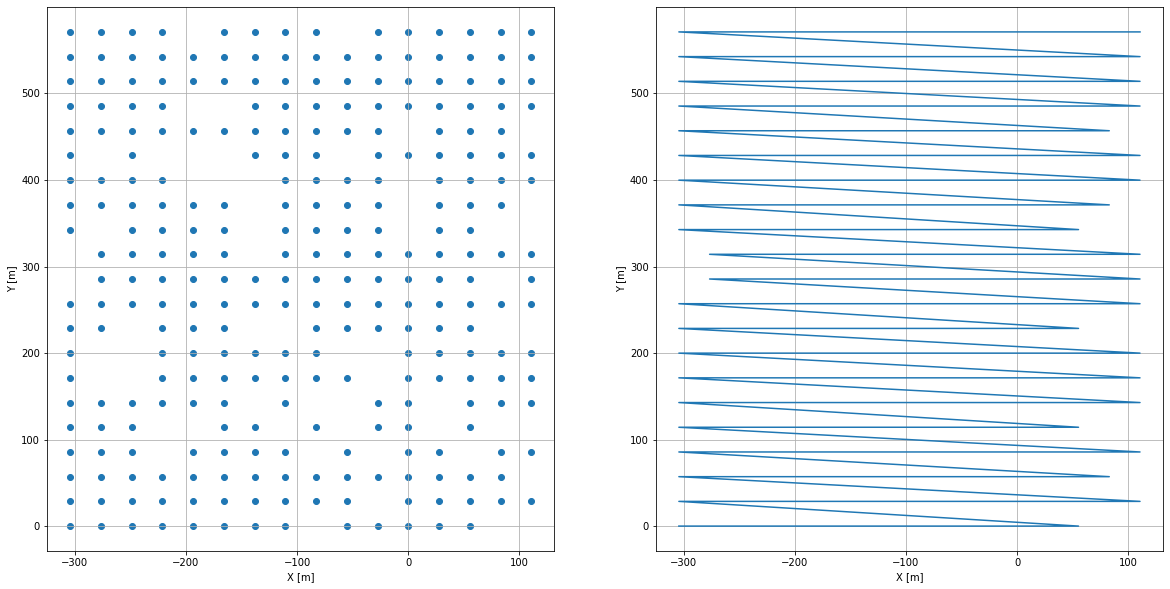

In [137]:
plt.rcParams['figure.figsize'] = [20, 10]

xs, ys = rp_df['rp_x'], rp_df['rp_y']
fig, ax = plt.subplots(1, 2)

ax[0].scatter(xs, ys)
ax[0].set_xlabel('X [m]')
ax[0].set_ylabel('Y [m]')
ax[0].grid()

ax[1].plot(xs, ys)
ax[1].set_xlabel('X [m]')
ax[1].set_ylabel('Y [m]')
ax[1].grid()

### Read in dataset - Signal Measurements Fingerprints

In [138]:
# Collect radio frequency measurements for each of the reference point and reformat it as 2D array
# Array structure:[[RSSI-1, TDoA-1], [RSSI-2, TDoA-2], ... , [RSSI-N,TDoA-N]] where N is the number of
# repeated samples taken at each reference point

# Read in each of the base station's data first
bs_137410 = np.loadtxt('cor137410.txt')
bs_143850 = np.loadtxt('cor143850.txt')
bs_144680 = np.loadtxt('cor144680.txt')
bs_734777 = np.loadtxt('cor734777.txt')
bs_734817 = np.loadtxt('cor734817.txt')
bs_748823 = np.loadtxt('cor748823.txt')
bs_749197 = np.loadtxt('cor749197.txt')

basestations = [bs_137410, bs_143850, bs_144680, bs_734777, bs_734817, bs_748823, bs_749197]

# Constants
num_rps = 277
num_samples = 100
num_bs = 7
num_featuresperbs = 2

# (277,100,14)
fp_array = np.zeros((277,100,14), dtype = np.float64)

for i in range(num_rps):
    
    cur_rp_measurements = []
    
    for j in range(num_bs):
        
        cur_bs = basestations[j]
        cur_rp_bs_measurements = cur_bs[i::num_rps]       
        
        rssi_samples, tdoa_samples = cur_rp_bs_measurements[:,0], cur_rp_bs_measurements[:,1]
        cur_rp_measurements.append(rssi_samples)
        cur_rp_measurements.append(tdoa_samples)
        
    cur_rp_measurements = np.array(cur_rp_measurements)
    cur_rp_measurements = cur_rp_measurements.T

    fp_array[i] = cur_rp_measurements

print(fp_array.shape)

(277, 100, 14)


## Step 2: Generate virtual RPs
- Split into train and test dataset
- Generate virtual RPs for RPs in train dataset

### Split into train and test dataset

In [139]:
# Currently, 
# rp_coords stores the coordinate information of each RP --> shape: (277,4)
# fp_array stores the fingerprint sample of each RP --> shape: (277, 100, 14)

# Split known RPs into train and validation
from sklearn.model_selection import train_test_split

X = rp_coords
y = fp_array

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(249, 4) (249, 100, 14) (28, 4) (28, 100, 14)


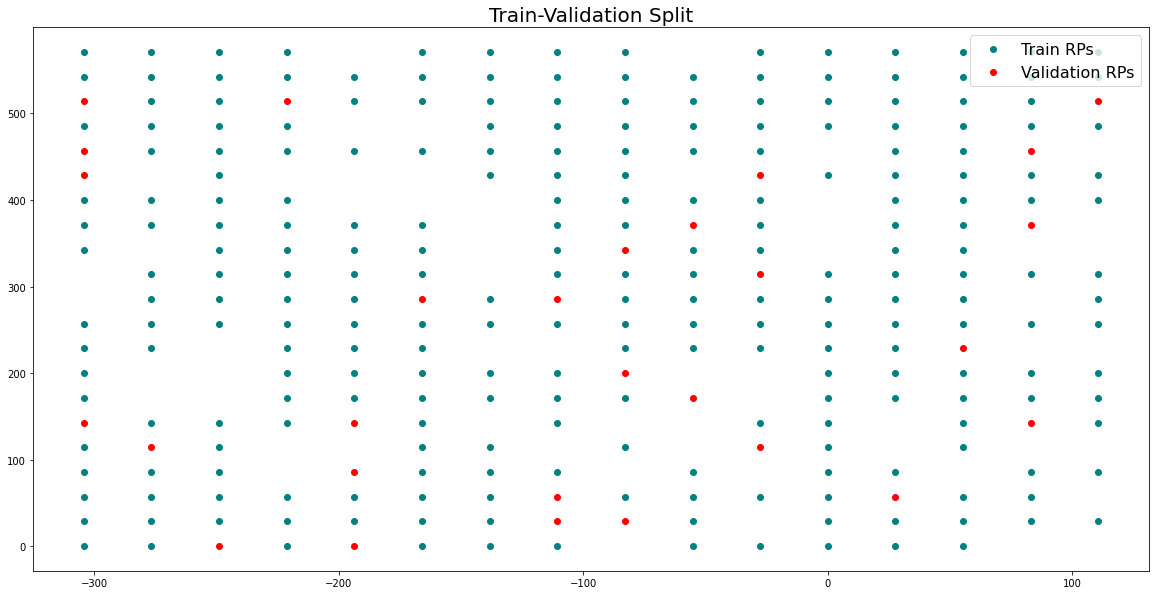

In [140]:
# Visualise RPs in train and validation dataset
plt.rcParams['figure.figsize'] = [20, 10]

plt.title('Train-Validation Split', fontsize = 20)
plt.scatter(X_train[:,2], X_train[:,3], color = 'teal', label = 'Train RPs')
plt.scatter(X_val[:,2], X_val[:,3], color = 'red', label = 'Validation RPs')
plt.legend(loc = 'upper right', fontsize = 16)

### Generate virtual RPs for RPs in train dataset

In [141]:
# Function to convert from x,y back to lat,long
import math

def get_lat_lon(origin_lat, origin_lon, x, y):
    # Convert x-y coordinates to latitude and longitude

    # Define the parameters used in the conversion
    R = 6378137  # Earth's radius in meters
    offset = R * math.pi  # Offset to ensure positive y-values

    # Convert x-y coordinates to latitude and longitude
    lat = origin_lat - (y / R) * 180 / math.pi
    lon = origin_lon + (x / (R * math.cos(origin_lat * math.pi / 180))) * 180 / math.pi

    return lat, lon

In [142]:
rp_indexes = [i for i in range(len(X_train))]
rp_lat = X_train[:,0]
rp_long = X_train[:,1]
rp_x = X_train[:,2]
rp_y = X_train[:,3]

X_train_data = {'rp_index': rp_indexes, 'rp_lat': rp_lat, 'rp_long': rp_long, 'rp_x': rp_x, 'rp_y': rp_y}
X_train_df = pd.DataFrame(data = X_train_data)

In [143]:
X_train_df.iloc[100]

rp_index    100.000000
rp_lat        1.353074
rp_long     103.687168
rp_x       -110.635768
rp_y        199.888889
Name: 100, dtype: float64

In [144]:
# Get maximum and minimum of x and y coordinates
def get_minmax(axis):
    
    if axis == 'x':
        x_coords = X_train[:,2]
        return (np.amin(x_coords), np.amax(x_coords))

    elif axis == 'y':
        y_coords = X_train[:,3]
        return (np.amin(y_coords), np.amax(y_coords))

# Want to generate 100 equidistance intervals on the y-axis, 20 equidistance intervals on the x-axis
def generate_virtualrps(x_num_rps, y_num_rps):
    
    # Get min and max for each axis
    x_min, x_max = get_minmax('x')
    y_min, y_max = get_minmax('y')
    
    # Find out number of virtual RPs generated along each axis
    x_stepsize = (x_max - x_min) / x_num_rps
    y_stepsize = (y_max - y_min) / y_num_rps
    
    # Create a numpy array to store results
    results = np.zeros((y_num_rps*x_num_rps, 4), dtype = np.float64)
    
    # Generate virtual RPs
    for i in range(0,y_num_rps,2):
        for j in range(0,x_num_rps,2):
            
            # Get coordinates for the current virtual RP
            cur_x_coords = x_min + j*x_stepsize
            cur_y_coords = y_min + i*y_stepsize
            
            # Get lat and long for the current coordinates
            cur_lat, cur_lon = get_lat_lon(origin_lat, origin_lon, cur_x_coords, cur_y_coords)
            results[(i*x_num_rps) + j] = (cur_lat, cur_lon, cur_x_coords, cur_y_coords)
    
    return results

In [145]:
virtual_rps = generate_virtualrps(50, 50)
print(virtual_rps.shape)

(2500, 4)


In [146]:
# (lat, lon, x_coords, y_coords)
print(virtual_rps)

[[   1.354873    103.68343812 -304.24857115    0.        ]
 [   0.            0.            0.            0.        ]
 [   1.354873    103.68358724 -287.65319454    0.        ]
 ...
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]]


In [147]:
# Concatenate the numpy arrays for actual and generated RPs
actual_rps = np.copy(X_train)

# Add a flag to virtual RPs to indicate that they are virtual
# Add a flag to original RPs to indicate that they are original RPs
actual_rps_flag = np.ones((len(actual_rps),))
virtual_rps_flag = np.zeros((len(virtual_rps),))

actual_rps = np.insert(actual_rps, 4, actual_rps_flag, axis = 1)
virtual_rps = np.insert(virtual_rps, 4, virtual_rps_flag, axis = 1)

# Concatenate arrays
X_train_augmented = np.concatenate((actual_rps, virtual_rps), axis = 0)

print(X_train_augmented.shape)

(2749, 5)


In [148]:
print(X_train_augmented)

[[   1.349733    103.687666   -165.95376608  571.11111111    1.        ]
 [   1.351789    103.688164   -221.27159436  342.66666667    1.        ]
 [   1.34999     103.687168   -110.6358382   542.55555556    1.        ]
 ...
 [   0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.        ]]


In [149]:
# Make a pandas dataframe
rp_indexes = [i for i in range(len(X_train_augmented))]
rp_lat = X_train_augmented[:,0]
rp_long = X_train_augmented[:,1]
rp_x = X_train_augmented[:,2]
rp_y = X_train_augmented[:,3]
rp_isactual_flag = X_train_augmented[:,4]

X_train_augmenteddata = {'rp_index': rp_indexes, 'rp_lat': rp_lat, 'rp_long': rp_long, 'rp_x': rp_x, 'rp_y': rp_y, 'is_actual': rp_isactual_flag}
X_train_augmented_df = pd.DataFrame(data = X_train_augmenteddata)

X_train_augmented_df.head(10)

,rp_index,rp_lat,rp_long,rp_x,rp_y,is_actual
0,0,1.349733,103.687666,-165.953766,571.111111,1.0
1,1,1.351789,103.688164,-221.271594,342.666667,1.0
2,2,1.349990,103.687168,-110.635838,542.555556,1.0
3,3,1.352560,103.686670,-55.317890,257.000000,1.0
4,4,1.349990,103.687666,-165.953757,542.555556,1.0
5,5,1.352817,103.686172,0.000000,228.444444,1.0
6,6,1.354102,103.686172,0.000000,85.666667,1.0
7,7,1.351018,103.685425,82.976861,428.333333,1.0
8,8,1.354102,103.688911,-304.248297,85.666667,1.0
9,9,1.354616,103.688662,-276.589332,28.555556,1.0


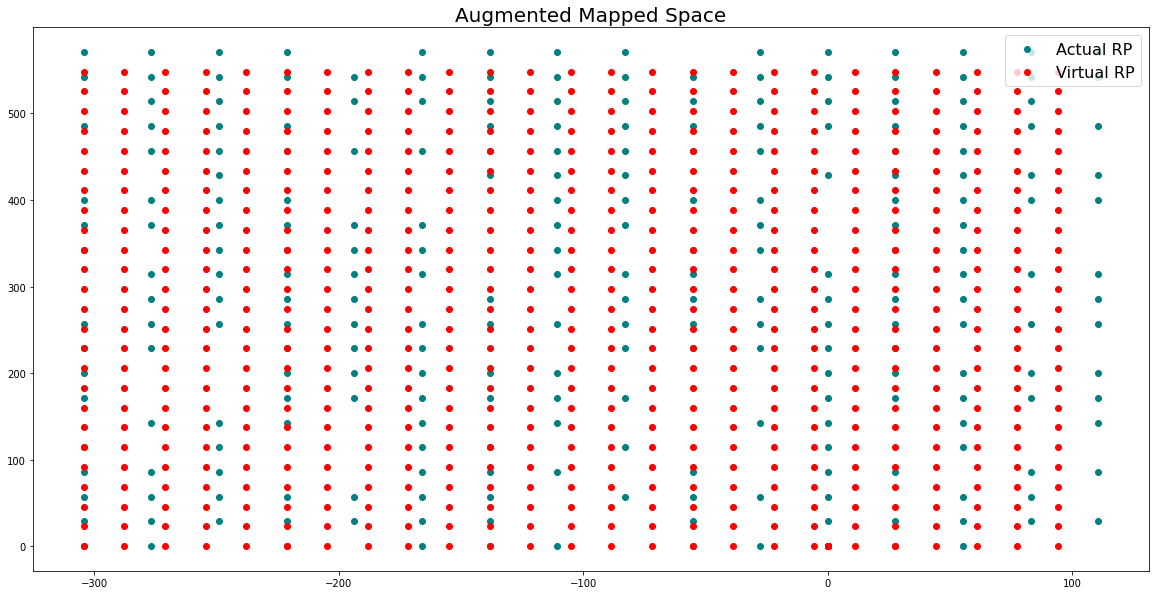

In [150]:
plt.rcParams['figure.figsize'] = [20, 10]

# Subset the actual and non-vritual RPs
actual_rps_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
virtual_rps_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 0.0]

plt.title('Augmented Mapped Space', fontsize = 20)
plt.scatter(actual_rps_df['rp_x'], actual_rps_df['rp_y'], color = 'teal', label = 'Actual RP')
plt.scatter(virtual_rps_df['rp_x'], virtual_rps_df['rp_y'], color = 'red', label = 'Virtual RP')
plt.legend(loc = 'upper right', fontsize = 16)

## Step 3: Combine real + virtual RP and make a undirectional, weighted, fully connected graph
- Construct the adjacency matrix, degree matrix then graph laplacian matrix

In [151]:
# Construct the distance matrix G - Shape of (2777, 2777)
ttal_rpcount = len(X_train_augmented_df.index)

# G_matrix: Store distances between points
# M_matrix: Store 1/0, depending on K closest neighbours
# W_matrix: Store adjacency matrix
# D_matrix: Store degree of each vertice
# L_matrix: Store the Graph Laplacian matrix

G_matrix = np.zeros((ttal_rpcount, ttal_rpcount), dtype = np.float64)
M_matrix = np.copy(G_matrix)
W_matrix = np.copy(G_matrix)
D_matrix = np.copy(G_matrix)
L_matrix = np.copy(G_matrix)

#  Determine the number of neighbours to be used in the construction of the graph
K = 50

In [152]:
print(os.getcwd())
os.chdir('../../data_augmentation')
print(os.getcwd())

/home/jovyan/committed_git/datasets/ntu_dataset
/home/jovyan/committed_git/data_augmentation


In [153]:
try:
    W_matrix = np.load('graphsage_adjmatrix_k50.npy')
    D_matrix = np.load('graphsage_dmatrix_k50.npy')
    L_matrix = np.load('graphsage_lmatrix_k50.npy')
    
except OSError as e:
    print("Have not saved adjacency matrix")

In [154]:
# Function to get Euclidean Distance
import math

def get_euclidean_distance(coords1, coords2):

    temp = coords2 - coords1
    sum_square = np.dot(temp.T, temp)
    return np.sqrt(sum_square)

# Create G_matrix
# Find out euclidean distance for each pair of points and update distance matrix (G_matrix)
for i in range(ttal_rpcount):
    
    coords1 = np.array((X_train_augmented_df.iloc[i]['rp_x'], X_train_augmented_df.iloc[i]['rp_y']), dtype = np.float64)
        
    for j in range(ttal_rpcount):
        
        # Prevent the node from having the closest distance to itself
        # Prevent self loops
        if j == i:
            G_matrix[i][j] = math.inf
        
        else:
            coords2 = np.array((X_train_augmented_df.iloc[j]['rp_x'], X_train_augmented_df.iloc[j]['rp_y']), dtype = np.float64)
            euclidean_distance = get_euclidean_distance(coords1, coords2)
            G_matrix[i][j] = euclidean_distance

KeyboardInterrupt: 

In [ ]:
# Create M_matrix
for i in range(ttal_rpcount):
    
    dists = G_matrix[i]
    k_nearest_indexes = np.argsort(dists)[:K]
    
    for idx in k_nearest_indexes:
        M_matrix[i][idx] = 1

In [ ]:
# Create W_matrix
for i in range(ttal_rpcount):
    for j in range(ttal_rpcount):
        
        # Prevent self-loops
        if M_matrix[i][j] == 1:
            if G_matrix[i][j] == 0:
                W_matrix[i][j] = 1e5
                
            else:
                W_matrix[i][j] = M_matrix[i][j] / (G_matrix[i][j] ** 2)

In [ ]:
# Create D_matrix
for i in range(ttal_rpcount):
    
    # Count the number of edges
    vertex_degree = np.count_nonzero(W_matrix[i])
    
    # Assign count to diagonal of matrix
    D_matrix[i][i] = vertex_degree

In [ ]:
# Create L_matrix
L_matrix = D_matrix - W_matrix

In [155]:
print(W_matrix)
print('-------')
print(D_matrix)
print('-------')
print(L_matrix)

[[0.         0.         0.00025803 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00025803 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
-------
[[50.  0.  0. ...  0.  0.  0.]
 [ 0. 50.  0. ...  0.  0.  0.]
 [ 0.  0. 50. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 50.  0.  0.]
 [ 0.  0.  0. ...  0. 50.  0.]
 [ 0.  0.  0. ...  0.  0. 50.]]
-------
[[ 5.00000000e+01  0.00000000e+00 -2.58031695e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.00000000e+01  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.58031695e-04  0.00000000e+00  5.00000000e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.0000000

In [156]:
# Save adjacency matrix
np.save('graphsage_adjmatrix_k50.npy', W_matrix)
np.save('graphsage_dmatrix_k50.npy', D_matrix)
np.save('graphsage_lmatrix_k50.npy', L_matrix)

In [157]:
# Visualise the graph created above
import networkx as nx

class GraphVisualisation:
    
    def __init__(self, adj_matrix):
        
        self.graph = nx.Graph()
        self.nodes = self.graph.nodes()
        self.edges = self.graph.edges()
        self.get_edges(adj_matrix)
        
    def get_edges(self, adj_matrix):
        
        edges = []
        num_vertices = len(adj_matrix)
        
        for i in range(num_vertices):
            for j in range(i, num_vertices):
                
                if adj_matrix[i][j] != 0:
                    self.graph.add_edge(i, j, weight = adj_matrix[i][j])
    
    def visualise(self):
        nx.draw_networkx(self.graph, node_size = 500)
        plt.show()

In [158]:
graph_vis = GraphVisualisation(W_matrix)

## Step 4: Generate mini batches of graph (Subset a set of edges)

In [159]:
# Get the indexes of nodes originally from train and test
X_train_actual_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
X_train_virtual_df = X_train_augmented_df[X_train_augmented_df['is_actual'] != 1.0]

# Actual RP becomes train dataset
actual_rps_indexes = X_train_actual_df['rp_index'].unique()

np.random.shuffle(actual_rps_indexes)
train_size = round(int(len(actual_rps_indexes)*0.95))
print(train_size)
train_rps = actual_rps_indexes[:train_size]
val_rps = actual_rps_indexes[train_size:]

# Virtual RP gets split into validation and test dataset
virtual_rp_indexes = X_train_virtual_df['rp_index'].unique()
test_rps = virtual_rp_indexes

print(train_rps.shape, val_rps.shape, test_rps.shape)

236
(236,) (13,) (2500,)


In [160]:
# Mark the vertices in the graph on whether they are train, validation or test
# node_type = 1 for training, 0 for validation and -1 for test
for node_idx in graph_vis.graph.nodes():
    
    if node_idx in train_rps:
        graph_vis.graph.nodes[node_idx]['train'] = True
        graph_vis.graph.nodes[node_idx]['node_type'] = 1
    
    elif node_idx in val_rps:
        graph_vis.graph.nodes[node_idx]['val'] = True
        graph_vis.graph.nodes[node_idx]['node_type'] = 0
        
    else:
        graph_vis.graph.nodes[node_idx]['test'] = True
        graph_vis.graph.nodes[node_idx]['node_type'] = -1

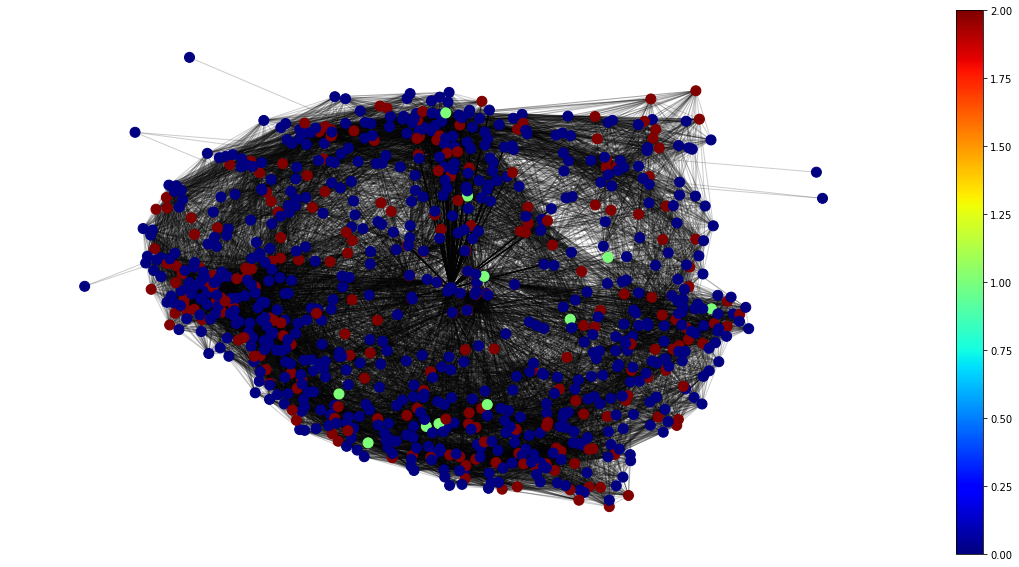

In [161]:
from itertools import count

# Colour legends
# Blue(0): Test, Green(1): Validation, Red(2): Train

# Get unique groups
groups = set(nx.get_node_attributes(graph_vis.graph, 'node_type').values())
mapping = dict(zip(sorted(groups), count()))
nodes = graph_vis.graph.nodes()
colours = [mapping[graph_vis.graph.nodes[n]['node_type']] for n in nodes]

pos = nx.spring_layout(graph_vis.graph)
ec = nx.draw_networkx_edges(graph_vis.graph, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(graph_vis.graph, pos, nodelist=nodes, node_color=colours, node_size=100, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [162]:
print(mapping)

{-1: 0, 0: 1, 1: 2}


In [329]:
# PLaceholder to store values for selected constants
# May need to change content later

def construct_placeholders():
    
    # Define placeholders
    # tf.placeholder is deprecated, try to use tf.Variable as an alternative
    
    placeholders = {
        'batch1': tf.Variable(initial_value=(0,), dtype=tf.int32, shape=(None,), name='batch1', trainable = False),
        'batch2': tf.Variable(initial_value=(0,), dtype=tf.int32, shape=(None,), name='batch2', trainable = False),
        'neg_samples': tf.Variable(initial_value=(0,), dtype=tf.int32, shape=(None,), name='neg_sample_size', trainable = False),
        'dropout': tf.Variable(initial_value=0.0, shape=(), name='dropout', trainable = False),
        'batch_size': tf.Variable(initial_value=0, dtype=tf.int32, name='batch_size', trainable = False)
    }
    
    return placeholders

### Setup Documentation:

- Nodes are labelled with either train, validation or test
    - 249 nodes with known representations (236 in training, 13 in validation)
    - 2500 nodes with unknown representations (2500 in test)    
<br/>
- Edges are labelled with either train_removed or nothing
    - For all edges involving either a validation or test node, the edge will be labelled with 'train_removed'
    - Else, it is not labelled with anything

### Functional Documentation:

- **__init__()**: Initialise the iterator object
- **_remove_isolated()**: Remove nodes that are not part of graph or do not have edge to any other nodes
- **construct_adj()**: Construct adjacency matrix and degree matrix for training nodes
- **construct_test_adj()**: Consturct adjacency matrix for testing purposes. Similar to construct_adj() but do not discern whether node is a training or test/validation node
- **end()**: Boolean check if all batches have been processed
- **num_training_batches()**: Determine the number of training batches
- **batch_feed_dict()**: Load a current batch of edges into a dictionary
- **next_minibatch_feed_dict()**: Feed in the next minibatch into a dictionary
- **val_feed_dict()**: Feed in the next validation batch into a dictionary
- **incremental_val_feed_dict()**: Allows for incremental evaluation and processing of the validation set in smaller chunks or batches.
- **incremental_embed_feed_dict()**: Allows for incremental computation of node embeddings in smaller chunks or batches.
- **label_val()**: Get arrays for train edges and validation edges
- **shuffle()**: Shuffle the nodes and edges. Also reset the batch number

In [311]:
# Generate mini batches of the graph
# Set a random set so that results will be reproducible everytime
np.random.seed(42)

class EdgeMinibatchIterator(object):
    
    def __init__(self, G, nodeid_dict, nodetype_dict, placeholders, context_pairs = None, batch_size = 50, max_degree = 25,
                n2v_retrain = False, fixed_n2v = False, **kwargs):
        
        """ 
        This minibatch iterator iterates over batches of sampled edges or random pairs of co-occuring edges.

        G -- networkx graph
        nodeid_dict -- dict mapping node ids to index in feature tensor
        placeholders -- tensorflow placeholders object
        context_pairs -- if not none, then a list of co-occuring node pairs (from random walks)
        batch_size -- size of the minibatches
        max_degree -- maximum size of the downsampled adjacency lists
        """

        self.G = G
        self.nodeid_dict = nodeid_dict
        self.nodetype_dict = nodetype_dict
        self.placeholders = placeholders
        self.batch_size = batch_size
        self.max_degree = max_degree
        self.batch_num = 0
        
        # Shuffle the orders of the nodes
        self.nodes = np.random.permutation(G.nodes())
        
        for edge in self.G.edges():
            # Nodes that belong to val or test set are considered 'train_removed'
            if (self.get_node_type(edge[0]) == 'val' or self.get_node_type(edge[0]) == 'val' or \
               self.get_node_type(edge[0]) == 'test' or self.get_node_type(edge[0]) == 'test'):
                self.G[edge[0]][edge[1]]['train_removed'] = True
            else:
                self.G[edge[0]][edge[1]]['train_removed'] = False

        # Left to do: A function that helps differentiates between training and test nodes
        # self.adj is a 2 dimensional adjacency matrix for nodes used in training
        # self.deg is a 1 dimensional vector that contains the degree for each node used in training
        self.adj, self.deg = self.construct_adj()
        
        # Get the adjacency matrix for nodes used in test
        self.test_adj = self.construct_test_adj()
        
        # A node-context pair refers to a combination of a central node
        # in a graph and one of its neighboring nodes or context nodes.
        if context_pairs is None:
            edges = self.G.edges()
        else:
            edges = context_pairs
        
        self.train_edges = self.edges = np.random.permutation(edges)

        # Assume using n2v_retrain == False: Not using iterator to add new embeddings to a n2v model
        # Assume using fixed_n2v == False: Not retraining n2v with only existing nodes as context
        # Remove any nodes not found in the original graph and nodes that have no outgoing edges
        self.train_edges = self._remove_isolated(self.train_edges)
        
        # Consider all edges belonging to validation or test
        self.val_edges = [e for e in self.G.edges() if self.G[e[0]][e[1]]['train_removed']]
        
        print(len([n for n in self.G.nodes() if self.get_node_type(n) == 'train']), 'train nodes')
        print(len([n for n in self.G.nodes() if self.get_node_type(n) == 'val']), 'val nodes')
        print(len([n for n in self.G.nodes() if self.get_node_type(n) == 'test']), 'test nodes')
        self.val_set_size = len(self.val_edges)
     
    def get_node_type(self, node):
        return self.nodetype_dict[self.G.nodes[node]['node_type']]
    
    def _remove_isolated(self, edge_list):
        
        new_edge_list = []
        missing = 0
        
        for node1, node2 in edge_list:
            
            # Flag out any missing nodes that are not present
            if not node1 in self.G.nodes or not node2 in self.G.nodes:
                missing += 1
                continue
                
            # For any training nodes that have no edges with any other nodes,
            if (self.deg[self.nodeid_dict[node1]] == 0 or self.deg[self.nodeid_dict[node2]] == 0) \
                and (not self.get_node_type(node1) == 'test' or self.get_node_type(node1) == 'val') \
                and (not self.get_node_type(node2) == 'test' or self.get_node_type(node2) == 'val'):
                continue
                
            else:
                new_edge_list.append((node1, node2))
        
        print("Unexpected missing:", missing)
        return new_edge_list
    
    def construct_adj(self):

        # Have to use adjacency matrix specified in original code so as to be
        # in sync with the max_degree criteria
        adj = len(self.nodeid_dict)*np.ones((len(self.nodeid_dict)+1, self.max_degree))
        
        # Degree numpy array that keeps track of degree for each node
        deg = np.zeros((len(self.nodeid_dict), ), dtype = np.int64)
        
        for node_id in self.G.nodes():
            
            # Only process training nodes
            if self.get_node_type(node_id) == 'test' or self.get_node_type(node_id) == 'val':
                continue
                
            # Get all the neighbour for current node
            neighbours = np.array([self.nodeid_dict[neighbour] \
                        for neighbour in self.G.neighbors(node_id) \
                        if (not self.G[node_id][neighbour]['train_removed'])])
            
            # Get the degree for current node and update deg matrix
            deg[self.nodeid_dict[node_id]] = len(neighbours)
            
            # If node is an isolated node, continue
            if len(neighbours) == 0:
                continue
                
            # Ensure that every node has number of neighbours equal to max degree
            # by random sampling
            # GraphSAGE
            if len(neighbours) > self.max_degree:
                neighbours = np.random.choice(neighbours, self.max_degree, replace = False)
            
            elif len(neighbours) < self.max_degree:
                neighbours = np.random.choice(neighbours, self.max_degree, replace = True)
            
            # Assign the neighbours to the current node in the adjacency matrix
            adj[self.nodeid_dict[node_id], :] = neighbours
        
        return adj, deg
    
    # Similar to construct_adj, but here do not care if either of the nodes connected by an
    # edge is in the val or test dataset
    def construct_test_adj(self):
        
        # Have to use adjacency matrix specified in original code so as to be
        # in sync with the max_degree criteria
        adj = len(self.nodeid_dict)*np.ones((len(self.nodeid_dict)+1, self.max_degree))
        
        for node_id in self.G.nodes():
            
            # Get all the neighbour for current node
            neighbours = np.array([self.nodeid_dict[neighbour] \
                        for neighbour in self.G.neighbors(node_id)])
                        
            # If node is an isolated node, continue
            if len(neighbours) == 0:
                continue
                
            # Ensure that every node has number of neighbours equal to max degree
            # by random sampling
            # GraphSAGE
            if len(neighbours) > self.max_degree:
                neighbours = np.random.choice(neighbours, self.max_degree, replace = False)
            
            elif len(neighbours) < self.max_degree:
                neighbours = np.random.choice(neighbours, self.max_degree, replace = True)
            
            # Assign the neighbours to the current node in the adjacency matrix
            adj[self.nodeid_dict[node_id], :] = neighbours
        
        return adj
    
    # Returns a boolean on whether all batches have been successfully run through
    def end(self):
        return self.batch_size * self.batch_num >= len(self.train_edges)
    
    # Determine number of training batches
    def num_training_batches(self):
        # + 1 so will iterate till the last batch
        return (len(self.train_edges) // self.batch_size) + 1
    
    # Pass in current batch and store in a dictionary
    # This dict will be passed into the the model to be used
    def batch_feed_dict(self, batch_edges):
        batch1 = []
        batch2 = []
        
        for node1, node2 in batch_edges:
            batch1.append(self.nodeid_dict[node1])
            batch2.append(self.nodeid_dict[node2])
        
        feed_dict = {}
        feed_dict['batch_size'] = tf.constant(value=len(batch_edges), dtype=tf.int32, shape=(None), name='batch_size')
        feed_dict['batch1'] = tf.constant(value=batch1, dtype=tf.int32, shape=(None), name='batch1')
        feed_dict['batch2'] = tf.constant(value=batch2, dtype=tf.int32, shape=(None), name='batch2')
        
        return feed_dict
    
    # Pass in the next batch of edges amd update dicionary with it
    def next_minibatch_feed_dict(self):
        
        # Determine the start index
        start_index = self.batch_num*self.batch_size
        
        # Increment batch number
        self.batch_num += 1
        
        # Determine the end index - Minimum of last index and current batch num * batch size
        end_index = min(self.batch_num*self.batch_size, len(self.train_edges)) 
        
        # SLice the array of batch_edges to get the current sample
        curbatch_edges = self.train_edges[start_index: end_index]
        
        # Feed the batches into function to generate batch dictionary
        curbatch_feed_dict = self.batch_feed_dict(curbatch_edges)
        
        # Return the batch dictionary
        return curbatch_feed_dict
    
    # Feed in validation edges and store in a dictionary
    # size is the desired size of the validation set
    def val_feed_dict(self, size = None):
        
        edge_list = self.val_edges
        
        # If no size was specified, return all validation edges
        if size == None:
            return self.batch_feed_dict(edge_list)
        
        # Else, permutate val edges and return the desired subset size
        else:
            ind = np.random.permutation(len(edge_list))
            val_edges = [edge_list[i] for i in range(min(size, len(ind)))]
            return self.batch_feed_dict(val_edges)
            
    # Allows for incremental evaluation and processing of the validation set in smaller chunks or batches.
    # size refers to batch size for each validation batch
    # iter_num refers to the current batch number
    def incremental_val_feed_dict(self, size, iter_num):
        
        edge_list = self.val_edges
        
        # Subset validaiton edge list to get back desired list of edges
        val_edges = edge_list[(size*iter_num): min((iter_num + 1)*size, len(edge_list))]
        
        # Returns current batch of validation edges, boolean on whether all batches processed, all validation edges
        return self.batch_feed_dict(val_edges), (iter_num + 1)*size >= len(self.val_edges), val_edges
            
    # Allows for incremental computation of node embeddings in smaller chunks or batches.
    # size refers to batch size for each validation batch
    # iter_num refers to the current batch number
    def incremental_embed_feed_dict(self, size, iter_num):
        
        node_list = self.G.nodes()
        
        # Get current batch of nodes
        val_nodes = node_list[(size*iter_num): min((iter_num + 1)*size, len(node_list))]
        val_edges = [(n,n) for n in val_nodes]
        return self.batch_feed_dict(val_edges), (iter_num + 1)*size >= len(node_list), val_edges
        
    # Label which edges are train edges, which edges are validation edges
    def label_val(self):
        
        train_edges = []
        val_edges = []
        
        for node1, node2 in self.G.edges():
            
            if (self.get_node_type(node1) == 'test' or self.get_node_type(node1) == 'val') or \
            (self.get_node_type(node2) == 'test' or self.get_node_type(node2) == 'val'):
                val_edges.append(node1, node2)
            else:
                train_edges.append(node1, node2)
                
        return train_edges, val_edges
    
    # Shuffles nodes and edges and reset batch number to repeat process
    def shuffle(self):
        """ 
        Re-shuffle the training set.
        Also reset the batch number.
        """
        
        self.train_edges = np.random.permutation(self.train_edges)
        self.nodes = np.random.permutation(self.nodes)
        self.batch_num = 0

Unexpected missing: 0
236 train nodes
13 val nodes
1763 test nodes


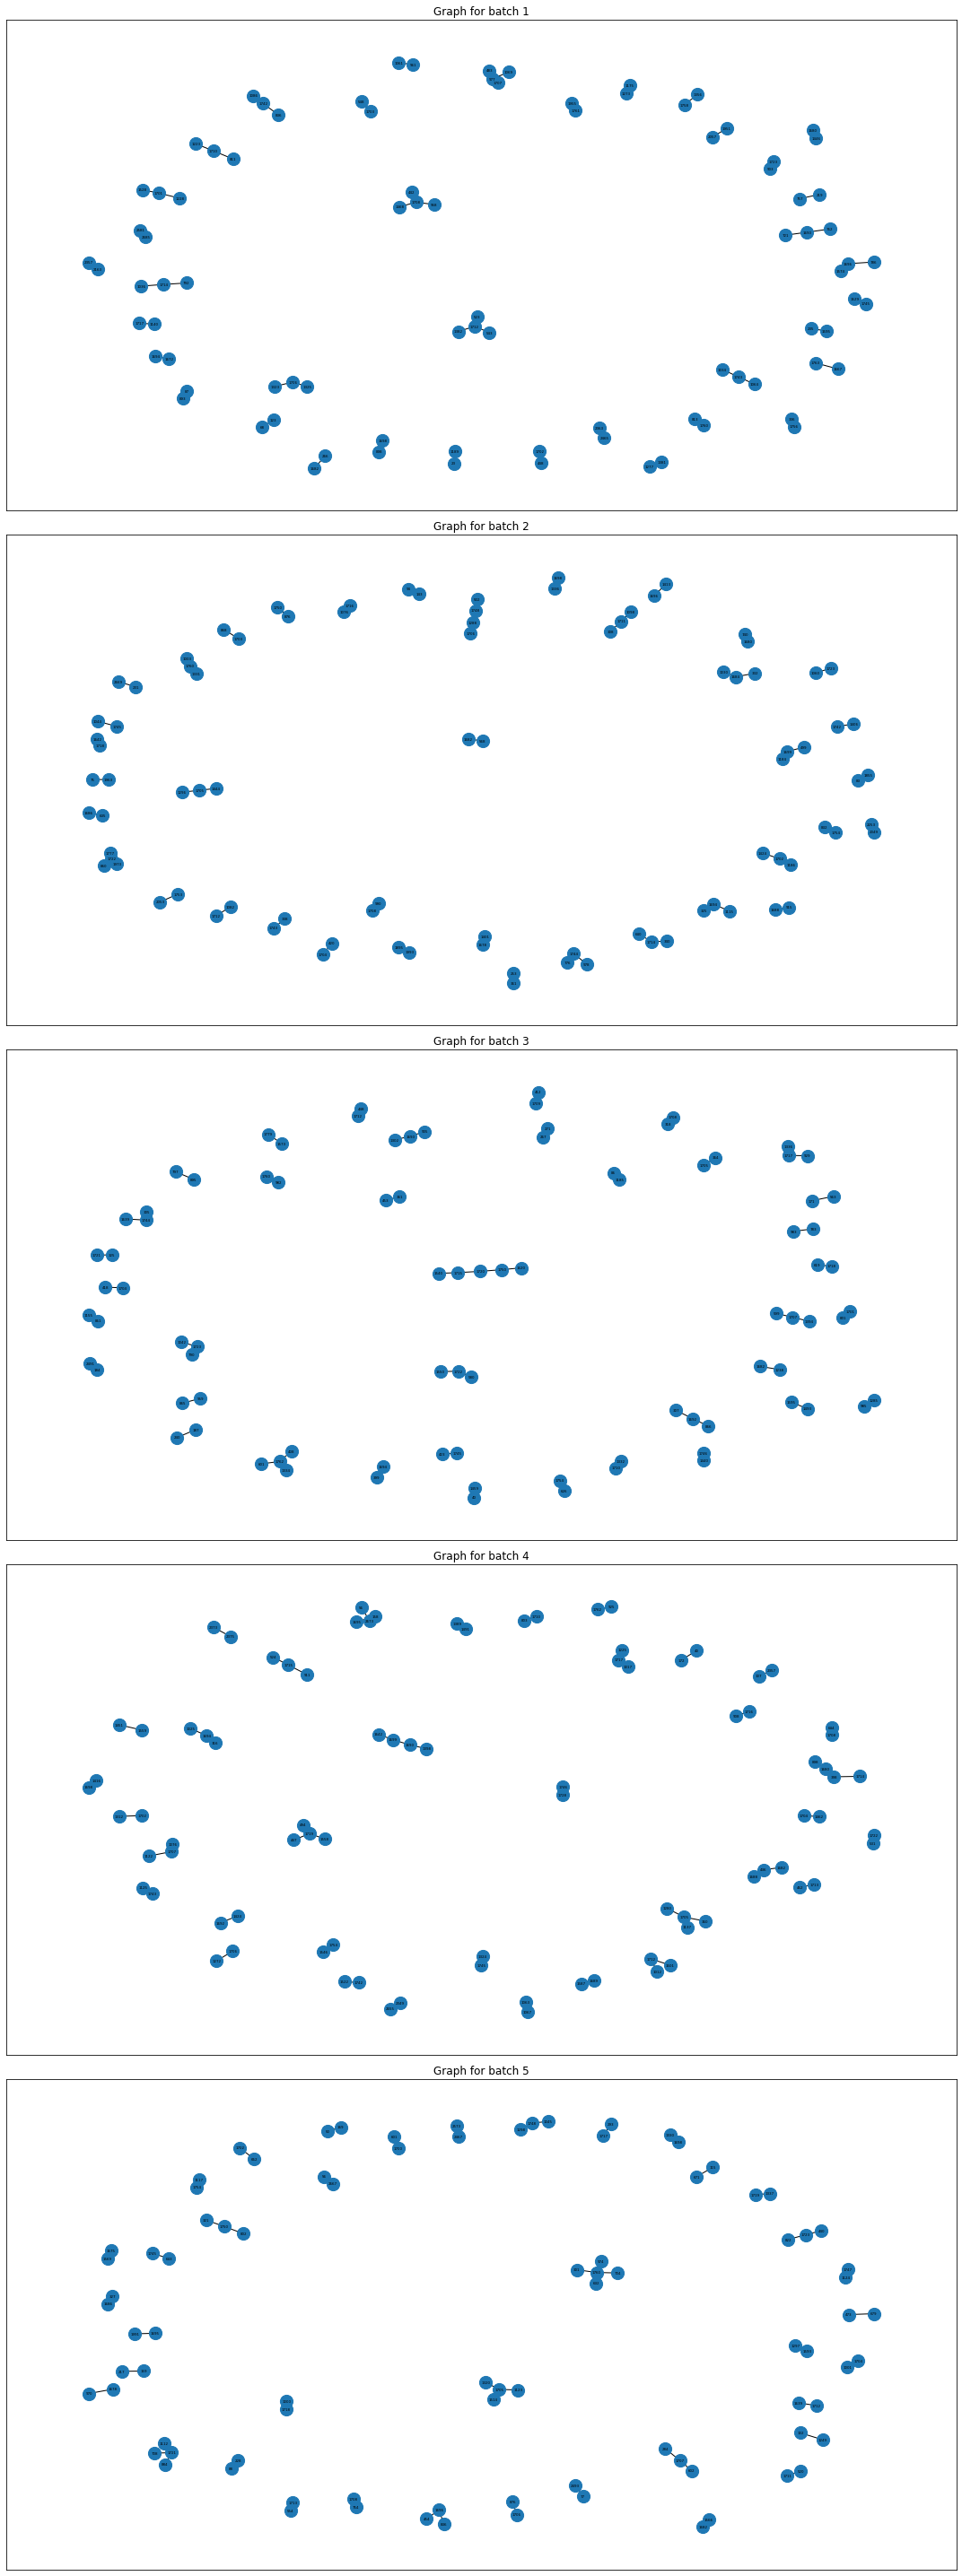

In [325]:
# Generate node mapping dictionary
rp_mapped_dict = {}
rp_indexes = X_train_augmented_df['rp_index']
for i,v in enumerate(rp_indexes):
    rp_mapped_dict[i] = i
    
# Instantiate EdgeMinibatchIterator object
placeholders = construct_placeholders()
nodetype_dict = {1: 'train',
                 0: 'val',
                 -1: 'test'}
minibatch = EdgeMinibatchIterator(graph_vis.graph, rp_mapped_dict, nodetype_dict, 
                                 placeholders, max_degree = 50, num_neg_samples = 20)

# Plot out the graph for each batch and observe
minibatch.shuffle()

# Iterate through the mini batches and observe the graphs
# Plot first ten batches
num_rows = 5
fig, axs = plt.subplots(num_rows, 1, figsize = (15,40))

for i in range(num_rows):

    ax = axs[i]    
    feed_dict = minibatch.next_minibatch_feed_dict()
    batch1 = feed_dict['batch1'].numpy()
    batch2 = feed_dict['batch2'].numpy()

    curbatch_graph = nx.Graph()

    for j in range(len(batch1)):
        curbatch_graph.add_edge(batch1[j], batch2[j])

    nx.draw_networkx(curbatch_graph, ax = ax, node_size = 200, font_size = 4)
    ax.set_title(f'Graph for batch {i + 1}')

plt.tight_layout()
plt.show()

## Step 5: Create custom layers inherited from keras.layers.Layer

In [344]:
from tensorflow import keras
from keras import Model
from keras.layers import Layer
import time

In [167]:
# Helper function, to assign unique layer ids
LAYER_UIDS = {}

def get_layer_uid(layer_name = ''):
    
    if layer_name not in LAYER_UIDS:
        LAYER_UIDS[layer_name] = 1
        return 1
    
    else:
        LAYER_UIDS[layer_name] += 1
        return LAYER_UIDS[layer_name]

In [168]:
# Helper functions, to initialise weights in hidden layers

# Uniform initialiser
def uniform(shape, scale = 0.05, name = None):
    initial = tf.random_uniform(shape, minval = -scale, maxval = scale, dtype = tf.float32)
    return tf.Variable(initial, name = name)

# Glorot initialiser
def glorot(shape, name = None):
    init_range = np.sqrt(6.0/(shape[0]+shape[1]))
    initial = tf.random_uniform(shape, minval=-init_range, maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)

# Zero initialiser
def zeros(shape, name=None):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

# Ones initialiser
def ones(shape, name=None):
    initial = tf.ones(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

In [415]:
'''
Inherit from keras.layers.Layer to implement sampling and aggregation layer
'''

# Base layer
class BaseLayer(Layer):
    
    # Initialise layer
    def __init__(self, num_outputs, **kwargs):
        
        super(BaseLayer, self).__init__()
        self.num_outputs = num_outputs
        '''
        allowed_kwargs = {'name', 'logging', 'model_size'}
        
        # Prevent any unallowed kwargs
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument' + kwarg
        
        layer_name = kwargs.get('name')
        if not layer_name:
            layer_name = self.__class__.name__.lower()
            name = layer_name + '_' + str(get_layer_uid(layer_name))
        
        self.name = name
        '''
        self.logging = kwargs.get('logging', False)
        self.sparse_inputs = False
    
    # Writing function for build is optional, do not have to write it here and can leave it to subclasses to define their own build
    
    # Function to be inherited by subclasses (Run input through layer to get output)
    def _call(self, inputs):
        return inputs
    
    # Wrapper for _call
    def call(self, inputs):
        
        if self.logging and not self.sparse_inputs:
            # tf.summary.histogram(<logging directory>, <items to be logged>)
            tf.summary.histogram(self.name + '/inputs', inputs)

        outputs = self._call(inputs)

        if self.logging:
            tf.summary.histogram(self.name + '/outputs', outputs)

        return outputs
    
# Sampling layer
# TODO: Make sampler sample according to edge weights instead, with nearer nodes of higher priority
class UniformNeighbourSampler(BaseLayer):
    
    # Initialise layer
    def __init__(self, num_outputs, **kwargs):
        
        super(UniformNeighbourSampler, self).__init__(num_outputs, **kwargs)
        
    # Writing function for build is optional, do not have to write it here since sampling layer has no trainable parameters     
    
    def _call(self, inputs):
        
        adj_info, ids, num_samples = inputs
        
        # To get back the neighbours of a vertice
        # self.adj_info: A numpy array of shape (no. of nodes, max degree) --> (2749, 50)
        # ids refer to node_id of each neighbour for the current node
        # Look up and return all neighbours of the current node
        
        # E.g., have 5 nodes that I want to sample from the current node, this function returns
        # the neighbours of these 5 nodes with the given ids 
        adj_lists = tf.nn.embedding_lookup(adj_info, np.asarray(ids, dtype = np.int32))
        
        # tf.random_shuffle shuffles elements along the 0th axis
        # 0-th axis (first dimension) refers to each neighbour of the current node
        # 1-th axis (second dimension) refers to neighbours of the neighbour 
        adj_lists = tf.transpose(tf.random.shuffle(tf.transpose(adj_lists)))
    
        # Slice the shuffled array to get back the number of samples required
        # [0, 0]: slice from the 0th index in the first dimension, 0th index in the second dimension 
        # [-1, num_samples]: Slice everything in first dimension, slice num_samples in second dimension
        adj_lists = tf.slice(adj_lists, [0, 0], [-1, num_samples])
        
        return adj_lists
    
# Aggregation layer
class MeanAggregator(BaseLayer):
    
    # Initialise layer
    def __init__(self, num_outputs, dropout = 0, bias = False, 
                 name = None, concat = False, **kwargs):
        
        super(MeanAggregator, self).__init__(num_outputs, **kwargs)
        
        # Initialise known attributes at initialisation
        self.dropout = dropout
        self.concat = concat
        self.bias = bias
    
    # Writing function for build since aggreagation layer has trainable parameters
    # input_shape: (neigh_input_dim, input_dim, output_dim)
    def build(self, input_shape):
               
        # Input is the neighbour nodes and their features
        input_dim = input_shape[1][2]
        neigh_input_dim = input_shape[1][2]
        input_batchsize = input_shape[1][0]
        
        # Output is the base nodes we are trying to learn the features off
        output_dim = input_shape[0][1]    
        
        # Initialise weights
        neigh_weights_initialiser = tf.keras.initializers.GlorotUniform()
        self.neigh_weights = self.add_weight(name = 'neigh_weights', shape = (neigh_input_dim, output_dim),
                                             initializer = neigh_weights_initialiser, trainable = True)
        
        self_weights_initialiser = tf.keras.initializers.GlorotUniform()
        self.self_weights = self.add_weight(name = 'self_weights', shape = (input_dim, output_dim),
                                            initializer = self_weights_initialiser, trainable = True)
        
        # Initialise bias
        if self.bias:
            # TODO: fix shape of bias vector
            self.bias_vals = tf.Variable(name = 'bias', initial_value = tf.zeros((output_dim), dtype = tf.float32), trainable = True)
        
    def _call(self, inputs):
        
        # Feature representation for base nodes, feature representation for neighbour nodes
        self_vecs, neigh_vecs = inputs
        input_batchsize = self_vecs.shape[0] # 50
        output_dim = self_vecs.shape[1] # 14
        
        # Perform dropout
        neigh_vecs = tf.nn.dropout(neigh_vecs, .999 - self.dropout)
        self_vecs = tf.nn.dropout(self_vecs, .999 - self.dropout)
        
        # Array to store output
        output_np = np.zeros(shape = (input_batchsize, output_dim), dtype = np.float32)

        # Aggregate for each base node in batch
        for i in range(len(self_vecs)):
            
            # shape: (14,)
            cur_node_features = self_vecs[i]
            # shape: (5.14)
            neigh_nodes_features = neigh_vecs[i]
            
            # Aggregate features of neighbours by taking the mean
            # shape: (14,)
            neigh_nodes_mean = tf.reduce_mean(neigh_nodes_features, axis = 0)
            
            # Expand dims to perform matmul operation
            # shape: (14, 1)
            neigh_nodes_mean = tf.expand_dims(neigh_nodes_mean, axis = 1)
            cur_node_features = tf.expand_dims(cur_node_features, axis = 1)
            
            # shape: (14, 1)
            from_neighs = tf.matmul(self.neigh_weights, neigh_nodes_mean)
            from_self = tf.matmul(self.self_weights, cur_node_features)
            
            # Element wise addition if not concatenating else concate
            if not self.concat:
                # output shape: (14,1)
                output = tf.add_n([from_neighs, from_self])
            else:
                output = tf.concat([from_neighs, from_self], axis = 1)
            
            # Reduce dimensions to add with bias
            # shape: (14,)
            output = tf.squeeze(output)

            # Add bias, depending on self.bias
            if self.bias:
                output += self.bias_vals
            
            # output_np[i] shape: (14,)
            # output shape: (14,)
            output_np[i] = output
        
        output = tf.convert_to_tensor(output_np, np.float32)
        return output
    
# Link Prediction layer
class BipartiteEdgePredLayer(BaseLayer):
    
    # Initialise layer
    def __init__(self, input_dim1, input_dim2, num_outputs, dropout = 0.,
                 act = tf.nn.sigmoid, loss_fn = 'xent', neg_sample_weights = 1.0,
                 bias = False, bilinear_weights = False, **kwargs):
        
        # num_outputs = 1 (Outputs a likelihood term)
        super(BipartiteEdgePredLayer, self).__init__(num_outputs, **kwargs)

        # Initialise known attributes at initialisation
        self.act = act
        self.bias = bias
        self.eps = 1e-7  
        self.neg_sample_weights = neg_sample_weights
        self.bilinear_weights = bilinear_weights
        self.dropout = dropout
        
        # Margin for hinge loss
        self.margin = 0.1
        
        # num_outputs = 1 (Outputs a likelihood term)
        self.output_dim = 1
        
        # Initialise weights and bias
        if self.bilinear_weights:
            weights_initialiser = tf.keras.initializers.GlorotNormal()
            self._weights = self.add_weight(name = 'bipartite_weights', shape = (input_dim1, input_dim2),
                                          dtype = tf.float32, initializer = weights_initialiser,
                                          trainable = True)
        if self.bias:
            self.bias_vals = tf.Variable(name = 'bipartite_bias',
                                         initial_value = tf.zeros((input_dim2), dtype = tf.float32),
                                         trainable = True)
            
        # Determine loss function
        if loss_fn == 'xent':
            self.loss_fn = self._xent_loss
        elif loss_fn == 'skipgram':
            self.loss_fn = self._skipgram_loss
        elif loss_fn == 'hinge':
            self.loss_fn = self._hinge_loss
    
    # Get affinity score with positive samples
    def affinity(self, inputs1, inputs2):  
        """
        Affinity score between batch of inputs1 and inputs2.
        
        Args:
            inputs1: tensor of shape [batch_size x feature_size].
        """
        
        if self.bilinear_weights:
            prod = tf.matmul(inputs2, tf.transpose(self._weights))
            self.prod = prod
            aff = tf.reduce_sum(inputs1 * prod, axis = 1)
        
        else:
            aff = tf.reduce_sum(inputs1 * inputs2, axis = 1)
        
        return aff
    
    # Get affinity score with negative samples    
    def neg_cost(self, inputs1, neg_samples, hard_neg_samples = None):
        """ 
        For each input in batch, compute the sum of its affinity to negative samples.

        Returns:
            Tensor of shape [batch_size x num_neg_samples]. For each node, a list of affinities to
                negative samples is computed.
        """
        
        if self.bilinear_weights:
            inputs1 = tf.matmul(inputs1, self._weights)
        neg_aff = tf.matmul(inputs1, tf.transpose(neg_samples))
        return neg_aff

        
    # Calculate loss of layer
    def loss(self, inputs1, inputs2, neg_samples):
        """ 
        Negative sampling loss.
        
        Args:
            neg_samples: tensor of shape [num_neg_samples x input_dim2]. Negative samples for all
            inputs in batch inputs1.
        """
        return self.loss_fn(inputs1, inputs2, neg_samples)
    
    # Calculate cross entropy loss
    def _xent_loss(self, inputs1, inputs2, neg_samples, hard_neg_samples = None):
        '''
        Calculate cross entropy loss
        '''
        
        # Get affinity scores
        aff = self.affinity(inputs1, inputs2)
        neg_aff = self.neg_cost(inputs1, neg_samples, hard_neg_samples)
        
        # Get cross entropy score with positive and negative samples
        true_xent = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(aff), logits=aff)
        negative_xent = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(neg_aff), logits=neg_aff)
        
        # Calculate loss
        loss = tf.reduce_sum(true_xent) + self.neg_sample_weights * tf.reduce_sum(negative_xent)
        
        return loss
    
    def _skipgram_loss(self, inputs1, inputs2, neg_samples, hard_neg_samples = None):
        '''
        Calculate skipgram loss
        '''

        # Get affinity scores
        aff = self.affinity(inputs1, inputs2)
        neg_aff = self.neg_cost(inputs1, neg_samples, hard_neg_samples)
        
        # Calculate loss
        neg_cost = tf.log(tf.reduce_sum(tf.exp(neg_aff), axis=1))
        loss = tf.reduce_sum(aff - neg_cost)
        return loss
    
    def _hinge_loss(self, inputs1, inputs2, neg_samples, hard_neg_samples = None):
        '''
        Calculate hinge loss
        '''
        
        # Get affinity scores
        aff = self.affinity(inputs1, inputs2)
        neg_aff = self.neg_cost(inputs1, neg_samples, hard_neg_samples)
        
        # Calculate loss
        diff = tf.nn.relu(tf.subtract(neg_aff, tf.expand_dims(aff, 1) - self.margin), name='diff')
        loss = tf.reduce_sum(diff)
        self.neg_shape = tf.shape(neg_aff)
        return loss
    
    def weights_norm(self):
        return tf.nn.l2_norm(self._weights)
    
# To be worked on when there's sufficient time
# class MaxPoolingAggregator(BaseLayer):

## Step 6: Create SampleAndAggregate (SAGE) model inherited from keras.Model

In [420]:
'''
Inheritances: (In reference code)
Model --> GeneralisedModel --> SampleAndAggregate

Inheritances: (In own code)
GraphSAGE (No inheritance required from above)

Write out individual functions and construct from layers required
(No need for inheritance from base Model object or from keras.Model class)
'''

class GraphSAGE(Model):
    
    def __init__(self, placeholders, features, graph, adj, degrees, layer_infos,
                 model_name, neg_sample_size, concat = True, model_size = 'small',
                 logging = False, learning_rate = 0.00001, params_decay = 0., **kwargs):
        '''
        Args:
            - placeholders: Stanford TensorFlow placeholder object.
            - features: Numpy array with node features. 
                        NOTE: Pass a None object to train in featureless mode (identity features for nodes)!
            - adj: Numpy array with adjacency lists (padded with random re-samples)
            - degrees: Numpy array with node degrees. 
            - layer_infos: List of SAGEInfo namedtuples that describe the parameters of all 
                   the recursive layers. See SAGEInfo definition above.
            - concat: whether to concatenate during recursive iterations
            - aggregator_type: how to aggregate neighbor information
            - model_size: one of "small" and "big"
            - identity_dim: Set to positive int to use identity features (slow and cannot generalize, but better accuracy)
        '''
        
        super(GraphSAGE, self).__init__(**kwargs)

        self.model_name = model_name
        self.logging = logging
        
        # Determine info from placeholder - To be updated at every minibatch iteration instead
        # self.inputs1 = placeholders['batch1']
        # self.inputs2 = placeholders['batch2']
        # self.batch_size = placeholders['batch_size']
        self.neg_sample_size = neg_sample_size
        self.placeholders = placeholders
        
        self.model_size = model_size
        self.features = tf.Variable(tf.constant(features, dtype=tf.float32), trainable = False)
        
        # Determine whether to concat output of layers
        self.concat = concat
        
        # Get input graph
        self.graph = graph
        
        # Determine dims - the initial input dimension for the base nodes
        # and dimensions for each subsequent layer
        # Determine layer info
        self.dims = [0 if features is None else features.shape[1]] # Input dimensions for base node
        self.dims.extend([layer_infos[i].output_dim for i in range(len(layer_infos))])
        self.layer_infos = layer_infos
        
        # Params decays for trainable parameters in aggregator layers
        self.params_decay = params_decay
        
        # Initialise layers in the model
        # This model hops to a maximum depth of 2 and at each depth, sample and aggregate
        # Note: Reuse aggregator each time
        '''Samplers'''
        # num_outputs = 1 
        self.uniform_sampler = UniformNeighbourSampler(1, logging = self.logging) 
  
        '''Aggregators'''
        # input_shape: (neigh_input_dim, input_dim, output_dim)
        # Have one layer for each aggregator
        # num_outputs = 1

        self.layer0_aggregator = MeanAggregator(1, bias = True, concat = self.concat,
                                                logging = self.logging)
        self.layer1_aggregator = MeanAggregator(1, bias = True, concat = self.concat,
                                               logging = self.logging)
   
        '''Link Predictor'''
        dim_mult = 2 if self.concat else 1
        self.link_predictor = BipartiteEdgePredLayer(dim_mult*self.dims[-1], dim_mult*self.dims[-1],
                                                    1, act = tf.nn.sigmoid, bilinear_weights = True,
                                                    bias = True)
            
        # Determine optimiser
        self.optimiser = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        
        '''
        # Define SAGEInfo and layer_infos

        # SAGEInfo is a namedtuple that specifies the parameters 
        # of the recursive GraphSAGE layers
        SAGEInfo = namedtuple("SAGEInfo",
            ['layer_name', # name of the layer (to get feature embedding etc.)
             'num_samples',
             'output_dim' # the output (i.e., hidden) dimension
            ])

        # adj_info is adjacency matrix of graph that we want to learn its node representations
        # output_dim is decided by choice but to get the feature representation of nodes, the final layer's
        # output_dim should match the number of number of dimensions in the feature representation of nodes
        sampler = UniformNeighbourSampler(adj_info)
        layer_infos = [SAGEInfo("node", 10, 4),
                      SAGEInfo("node", 5, 4)]
        
        samples1, support_sizes1 = self.sample(self.inputs1, self.layer_infos)
        '''
    
    # Method to sample neighbours of a node
    def sample(self, inputs, layer_infos, batch_size = None):
        
        """ Sample neighbors to be the supportive fields for multi-layer convolutions.

        Args:
            inputs: batch inputs
            batch_size: the number of inputs (different for batch inputs and negative samples).
        """
        
        # Determine batch size
        if batch_size is None:
            batch_size = self.batch_size
            
        # Create arrays to store sampled inputs and no. of inputs sampled per layer
        
        samples = [inputs]
        sample_size = 1
        sample_sizes = [sample_size]
        
        # Iterate through each layer, starting from the layer furthest away
        for i in range(len(layer_infos)):
            
            # Let j be the index referring to current layer we are sampling at
            j = len(layer_infos) - i - 1
            
            # Run through sampler to get samples
            support_size = layer_infos[j].num_samples
            sampled_adj_list = self.uniform_sampler((self.adj_info, samples[i], support_size))
            batch_size = len(samples[i])
            
            # Append results to respective arrays
            # batch_size is number of nodes being sampled
            # support_size is number of neighbours chosen for each sampled node
            samples.append(tf.reshape(sampled_adj_list, [batch_size*support_size,]))
            sample_sizes.append(support_size)
        
        # samples: [base nodes to get representation for, nodes 2 layers away (Layer 2), nodes 1 layer away (Layer 1)]
        return samples, sample_sizes
    
    # Method to aggregate feature representation of nodes
    def aggregate(self, samples, input_features, dims, num_samples, support_sizes, batch_size = None,
                 name = None, concat = False, model_size = 'small'):
       
        """ At each layer, aggregate hidden representations of neighbors to compute the hidden representations 
            at next layer.
        
        Args:
            samples: a list of samples of variable hops away for convolving at each layer of the
                network. Length is the number of layers + 1. Each is a vector of node indices.
            input_features: the input features for each sample of various hops away.
            dims: a list of dimensions of the hidden representations from the input layer to the
                final layer. Length is the number of layers + 1.
            num_samples: list of number of samples for each layer.
            support_sizes: the number of nodes to gather information from for each layer.
            batch_size: the number of inputs (different for batch inputs and negative samples).
        Returns:
            The hidden representation at the final layer for all nodes in batch
        """
        
        # Determine batch size
        if batch_size is None:
            batch_size = self.batch_size
            
        # hidden is a list that contains the embeddings or hidden representations of the node samples from each layer.
        # Each element in the hidden list corresponds to a layer, and the shape of each element is determined by the number 
        # of node samples in that layer.
        # hidden: [base nodes to get representation for, nodes 2 layers away (Layer 2), nodes 1 layer away (Layer 1)]
        hidden = [tf.nn.embedding_lookup(input_features, np.asarray(node_samples, dtype = np.int32)) for node_samples in samples]
          
        # Start aggregating by layers
        for layer in range(len(num_samples)):
                                    
            # After determining aggregators, start from hops furthest away until reach back to base parent node
            next_hidden = []
                        
            for hop in range(len(num_samples) - layer):
                
                # Determine dimension multiplier
                dim_mult = 2 if concat and layer != 0 else 1
                
                # Convert batch size from tensor to numpy if needed
                if tf.is_tensor(batch_size):
                    batch_size = batch_size.numpy()
                    
                # Shape: [dims for current layer, dims for neighbour layer, dims of current layer]
                neigh_dims = [batch_size*support_sizes[hop], num_samples[len(num_samples) - hop - 1], dim_mult*dims[layer]]

                # Doing aggregator(input_data) calls .call() and .build() implictly
                if hop == len(num_samples) - 1:
                    aggregated_res = self.layer1_aggregator((hidden[hop], tf.reshape(hidden[hop + 1], neigh_dims)))
                else:
                    aggregated_res = tf.nn.relu(self.layer0_aggregator((hidden[hop], tf.reshape(hidden[hop + 1], neigh_dims))))
                
            next_hidden.append(aggregated_res)
                
        # Re-assign hidden as new aggregated output
        hidden = next_hidden
        
        # Return node representation of base node
        return hidden[0]

    # Method to get output from a given set of inputs
    def get_outputs(self):
        
        # Prepare neg_nodes
        labels = tf.reshape(tf.cast(self.inputs2, dtype = tf.int64), [self.batch_size, 1])
        
        # Convert numpy array to list and flatten 2D list to a 1D list
        unigrams = self.degrees.flatten()
        unigrams = list(unigrams)
        
        self.neg_samples, _, _ = tf.nn.fixed_unigram_candidate_sampler(
            true_classes=labels,
            num_true=1,
            num_sampled=self.neg_sample_size,
            unique=False,
            range_max=len(self.degrees),
            distortion=0.75,
            unigrams=unigrams)
         
        # Get the samples and support_size for batch1, batch2 and neg_nodes in an array
        samples_input1, support_sizes_input1 = self.sample(self.inputs1, self.layer_infos)
        samples_input2, support_sizes_input2 = self.sample(self.inputs2, self.layer_infos)
        neg_samples, neg_support_sizes = self.sample(self.neg_samples, self.layer_infos, self.neg_sample_size)
        
        # Get number of samples
        num_samples = [layer_info.num_samples for layer_info in self.layer_infos]
        
        # Aggregate the samples and get output
        input1_outputs = self.aggregate(samples_input1, [self.features], self.dims, num_samples,
                                  support_sizes_input1, concat = self.concat, model_size = self.model_size)
        input2_outputs = self.aggregate(samples_input2, [self.features], self.dims, num_samples,
                                  support_sizes_input2, concat = self.concat, model_size = self.model_size)
        neg_outputs = self.aggregate(neg_samples, [self.features], self.dims, num_samples, neg_support_sizes,
                                     batch_size = self.neg_sample_size, concat = self.concat, model_size = self.model_size)
        
        # Normalise the outputs
        input1_outputs = tf.nn.l2_normalize(input1_outputs, 1)
        input2_outputs = tf.nn.l2_normalize(input2_outputs, 1)
        neg_outputs = tf.nn.l2_normalize(neg_outputs, 1)
        
        # return feature representation for batch 1 nodes, " for batch 2 nodes, " for negative output nodes
        return (input1_outputs, input2_outputs, neg_outputs)
    
    # Method to calculate loss
    # Returns a loss, the lower the better
    def calc_loss(self, outputs):
        
        loss = 0.
        input1_outputs, input2_outputs, neg_outputs = outputs
        
        # Get aggregators
        aggregators = [self.layer0_aggregator, self.layer1_aggregator]
        
        # For each aggregator,
        for aggregator in aggregators:
    
            # Add l2 loss of aggregator's weights
            loss += self.params_decay * tf.nn.l2_loss(aggregator.neigh_weights)
            loss += self.params_decay * tf.nn.l2_loss(aggregator.self_weights)
            
            if aggregator.bias:
                loss += self.params_decay * tf.nn.l2_loss(aggregator.bias_vals)
            
        # Add loss from link prediction
        loss += self.link_predictor.loss(input1_outputs, input2_outputs, neg_outputs)
        
        tf.summary.scalar('loss', loss)
        return loss
        
    # Method to calculate accuracy
    # Returns Mean Reciprocal Rank (MRR), a value between 0 and 1.
    # The nearer the value to 1, the better
    def calc_acc(self, outputs):
        
        input1_outputs, input2_outputs, neg_outputs = outputs
        
        # Calculate affinity between positive samples
        aff = self.link_predictor.affinity(input1_outputs, input2_outputs)
        
        # Calculate affinity between positive and negative samples
        neg_aff = self.link_predictor.neg_cost(input1_outputs, neg_outputs)
        neg_aff = tf.reshape(neg_aff, [self.batch_size, self.neg_sample_size])
        
        # Combine both affinity values
        # shape: (x,) --> (x, 1)
        _aff = tf.expand_dims(aff, axis = 1)
        aff_all = tf.concat([neg_aff, _aff], axis = 1)
        size = tf.shape(aff_all)[1]
        
        # Get indices of ranks and ranks to calculate Mean Reciprocal Rank (MRR)
        _, indices_of_ranks = tf.nn.top_k(aff_all, k = size)
        _, ranks = tf.nn.top_k(-indices_of_ranks, k = size)
        mrr = tf.reduce_mean(tf.divide(1.0, tf.cast(ranks[:, -1] + 1, tf.float32)))
        
        tf.summary.scalar('mrr', mrr)
        return mrr
        
    # Custom method to train model
    def train_model(self, epochs, max_total_steps, validate_every, print_every):
        
        # Instantiate variables
        train_shadow_mrr = None
        val_shadow_mrr = None
        total_steps = 0
        avg_time = 0.0
        
        # Make edge minibatch iterator
        # TODO: Need to supply a graph and the necessary dictionaries to edge iterator
        # Graph should be constructed beforehand, a graph representing all vertices and edges
        # using the complete W_matrix. Then, follow steps taken in step 4
        # May need to pass in graph as a parameter to __init__() function of GraphSAGE model
        
        # Get rp_mapped_dicts
        rp_mapped_dict = {}
        for node_idx in self.graph.nodes():
            rp_mapped_dict[node_idx] = node_idx

        # Get nodetype_dict
        nodetype_dict = {1: 'train',
                 0: 'val',
                 -1: 'test'}
        
        minibatch = EdgeMinibatchIterator(self.graph, rp_mapped_dict, nodetype_dict, 
                                 placeholders, max_degree = 50, num_neg_samples = self.neg_sample_size)
        
        # Adjacency info and degrees should be taken from minibatch
        self.adj_info = minibatch.adj
        self.degrees = minibatch.deg
        
        # Get train and validation adjacency list
        # train_adjlist = minibatch.adj
        # val_adjlist = minibatch.test_adj
        
        with tf.GradientTape(persistent = True) as tape:
            
            # Iterate through epochs
            for epoch_no in range(epochs):

                print(f'Epoch {epoch_no + 1}')
                # Shuffle the minibatch
                minibatch.shuffle()

                batch_iter_no = 0
                # Iterate through all minibatches
                while not minibatch.end():

                    # Generate inputs to be fed into model
                    # Note: next_minibatch_feed_dict() feeds in the next batch of training edges
                    train_feed_dict = minibatch.next_minibatch_feed_dict()
                    self.inputs1 = train_feed_dict['batch1']
                    self.inputs2 = train_feed_dict['batch2']
                    self.batch_size = train_feed_dict['batch_size']
                    
                    # Start taking note of training time
                    start_time = time.time()
                    
                    # Pass in inputs to model and get outputs
                    input1_outputs, input2_outputs, neg_outputs = self.get_outputs()

                    # Run model on train inputs to get train_loss, train_mrr 
                    train_loss = self.calc_loss((input1_outputs, input2_outputs, neg_outputs))
                    train_loss = train_loss / tf.cast(self.batch_size, tf.float32)

                    train_mrr = self.calc_acc((input1_outputs, input2_outputs, neg_outputs))

                    # Calculate train_shadow_mrr (To provide a moving average of mrr to better evaluate
                    # performance over time)
                    if train_shadow_mrr is None:
                        train_shadow_mrr = train_mrr   
                    else:
                        train_shadow_mrr -= (1- 0.99)*(train_shadow_mrr - train_mrr)

                    # Note: val_feed_dict() feeds in the next batch of validation edges
                    # Run model on validation input every validate_iter iterations to get val_loss and val_mrr
                    if batch_iter_no % validate_every == 0:

                        val_feed_dict = minibatch.val_feed_dict(size = 10)
                        self.inputs1 = val_feed_dict['batch1']
                        self.inputs2 = val_feed_dict['batch2']
                        self.batch_size = val_feed_dict['batch_size']

                        input1_outputs, input2_outputs, neg_outputs = self.get_outputs()

                        val_loss = self.calc_loss((input1_outputs, input2_outputs, neg_outputs))
                        val_loss = val_loss / tf.cast(self.batch_size, tf.float32)

                        val_mrr = self.calc_acc((input1_outputs, input2_outputs, neg_outputs))

                        #  Calculate val_shadow_mrr (To provide a moving average of val_mrr to beter evaluate
                        # performance over time)
                        if val_shadow_mrr is None:
                            val_shadow_mrr = val_mrr    
                        else:
                            val_shadow_mrr -= (1- 0.99)*(val_shadow_mrr - val_mrr)

                    # Calculate gradient based on train loss and optimise weights and biases
                    # Compute gradients
                    # tape.gradient(<loss>, <list of trainable variables>)
                    gradients = tape.gradient(train_loss, self.trainable_variables,
                                              unconnected_gradients=tf.UnconnectedGradients.ZERO)
                    clipped_gradients = [tf.clip_by_value(grad, -5.0, 5.0) if grad is not None else None for grad in gradients]
                    # Apply gradients
                    self.optimiser.apply_gradients(zip(clipped_gradients, self.trainable_variables))               

                    # Calculate average time taken for each step (aka batch iteration)
                    end_time = time.time()
                    avg_time = (avg_time * total_steps + end_time - start_time) / (total_steps + 1)

                    # Print complete statistics every print_every iteration
                    if total_steps % print_every == 0:
                        print(f'Epoch {epoch_no}, Batch Iteration {batch_iter_no}')
                        print(f'train_loss: {train_loss:.6f}')
                        print(f'train_mrr: {train_mrr:.6f}')
                        print(f'train_mrr_ema: {train_shadow_mrr:.6f}')
                        print(f'val_loss: {val_loss:.6f}')
                        print(f'val_mrr: {val_mrr:.6f}')
                        print(f'val_mrr_ema: {val_shadow_mrr:.6f}')
                        print(f'average_time: {avg_time:.6f}')
                        print(self.trainable_variables[0][0])
                    batch_iter_no += 1
                    total_steps += 1

                    # If max number of steps reached, break
                    if total_steps > max_total_steps:
                        break

                # If max number of steps reached, break
                if total_steps > max_total_steps:
                    break
            
    # Method to save weights of trained model
    def save_model(self):
        pass
    
    # Method to loads of trained model
    def load_model(self):
        pass

## Step 7: Create node representations


### Forewords:
- Before creating the node representation for our reference points, would like to observe how the mean and variance of RSSI and TDoA vary across the RPs.
- One sample represents the true measurements received while the remaining 99 measurements were samples generated using AWGN at SNR40. (Patterns of mean and variance of RSSI and TDoA across RPs should be reflective across different SNR but the absolute values are only representative of the current SNR)

### Recall:
- Nodes are labelled with either train, validation or test
    - 249 nodes with known representations (236 in training, 13 in validation)
    - 2500 nodes with unknown representations (2500 in test) 
- Will only be using nodes with known representations for visualisation

In [171]:
# Use augmented_df from step 2
X_train_augmented_df.head(10)

,rp_index,rp_lat,rp_long,rp_x,rp_y,is_actual
0,0,1.349733,103.687666,-165.953766,571.111111,1.0
1,1,1.351789,103.688164,-221.271594,342.666667,1.0
2,2,1.349990,103.687168,-110.635838,542.555556,1.0
3,3,1.352560,103.686670,-55.317890,257.000000,1.0
4,4,1.349990,103.687666,-165.953757,542.555556,1.0
5,5,1.352817,103.686172,0.000000,228.444444,1.0
6,6,1.354102,103.686172,0.000000,85.666667,1.0
7,7,1.351018,103.685425,82.976861,428.333333,1.0
8,8,1.354102,103.688911,-304.248297,85.666667,1.0
9,9,1.354616,103.688662,-276.589332,28.555556,1.0


In [172]:
# Get dataframe known rps
# Get unique indexes of these rps
actual_rps_coords_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
actual_rps_indexes = actual_rps_coords_df['rp_index'].unique()

# Combine readings of each reference point with coordinate information (mean value from 100 repeated readings)
ttal_bs = 7

# Get headers
col_names = ['rp_index']
for i in range(ttal_bs):
    col_names.append(f'rssi_{i + 1}')
    col_names.append(f'tdoa_{i + 1}')

actual_rps_measurements = [fp for index, fp in enumerate(fp_array) if index in actual_rps_indexes]
actual_rps_measurements = np.array(actual_rps_measurements)

# Get data
avg_rps_measurements = np.mean(actual_rps_measurements, axis = 1)
actual_rps_indexes = np.expand_dims(np.array(actual_rps_indexes), axis = 1)
actual_rps_data = np.copy(avg_rps_measurements)

print(actual_rps_data.shape)
print(actual_rps_indexes.shape)

actual_rps_data = np.concatenate((actual_rps_indexes, actual_rps_data), axis= 1)

# Make dataframe
actual_rps_measurements_df = pd.DataFrame(data = actual_rps_data, columns = col_names)

# Join with dataframe that has coordinates of each rp
actual_rps_df = actual_rps_measurements_df.merge(actual_rps_coords_df, left_on = 'rp_index', right_on = 'rp_index')
actual_rps_df.head(5)

(249, 14)
(249, 1)


,rp_index,rssi_1,tdoa_1,rssi_2,tdoa_2,rssi_3,tdoa_3,rssi_4,tdoa_4,rssi_5,tdoa_5,rssi_6,tdoa_6,rssi_7,tdoa_7,rp_lat,rp_long,rp_x,rp_y,is_actual
0,0.0,-112.699389,-6.114592e-08,-40.506879,-6.827317e-07,-75.721837,4.475735e-07,-250.095429,-0.000002,-52.446473,0.0,-42.136285,0.000002,-34.635594,9.839608e-07,1.349733,103.687666,-165.953766,571.111111,1.0
1,1.0,-53.280194,9.390514e-07,-35.676996,-4.662520e-07,-75.969840,6.546643e-07,-249.835631,-0.000002,-56.714162,0.0,-46.242288,0.000002,-30.320515,8.577714e-07,1.351789,103.688164,-221.271594,342.666667,1.0
2,2.0,-75.627562,-9.216789e-07,-44.261304,-1.456547e-06,-95.937745,5.058945e-07,-249.868644,-0.000003,-64.615243,0.0,-48.193824,0.000002,-28.483558,9.070434e-07,1.349990,103.687168,-110.635838,542.555556,1.0
3,3.0,-250.028781,-2.116938e-06,-37.222663,-4.089625e-07,-54.293762,1.218730e-06,-64.853840,0.000003,-116.754853,0.0,-46.348583,0.000002,-50.161692,1.788194e-06,1.352560,103.686670,-55.317890,257.000000,1.0
4,4.0,-250.052709,-1.661306e-06,-37.231134,1.778100e-07,-62.362595,2.693477e-06,-77.907933,0.000004,-49.915859,0.0,-49.339566,0.000001,-51.583862,9.266309e-07,1.349990,103.687666,-165.953757,542.555556,1.0


In [173]:
# Normalise values of RSSI and TDOA to range of (0,1)
'''
Scaling to a range of (0,1) is good when:
- Know approximate upper and lower bounds on data with few or no outliers
- Data is approximately uniformly distributed across that range
'''
def scale_down(raw_x, min_val, max_val):
    return (raw_x - min_val) / (max_val - min_val)

def scale_up(scaled_x, min_val, max_val):
    return min_val + scaled_x*(max_val - min_val)

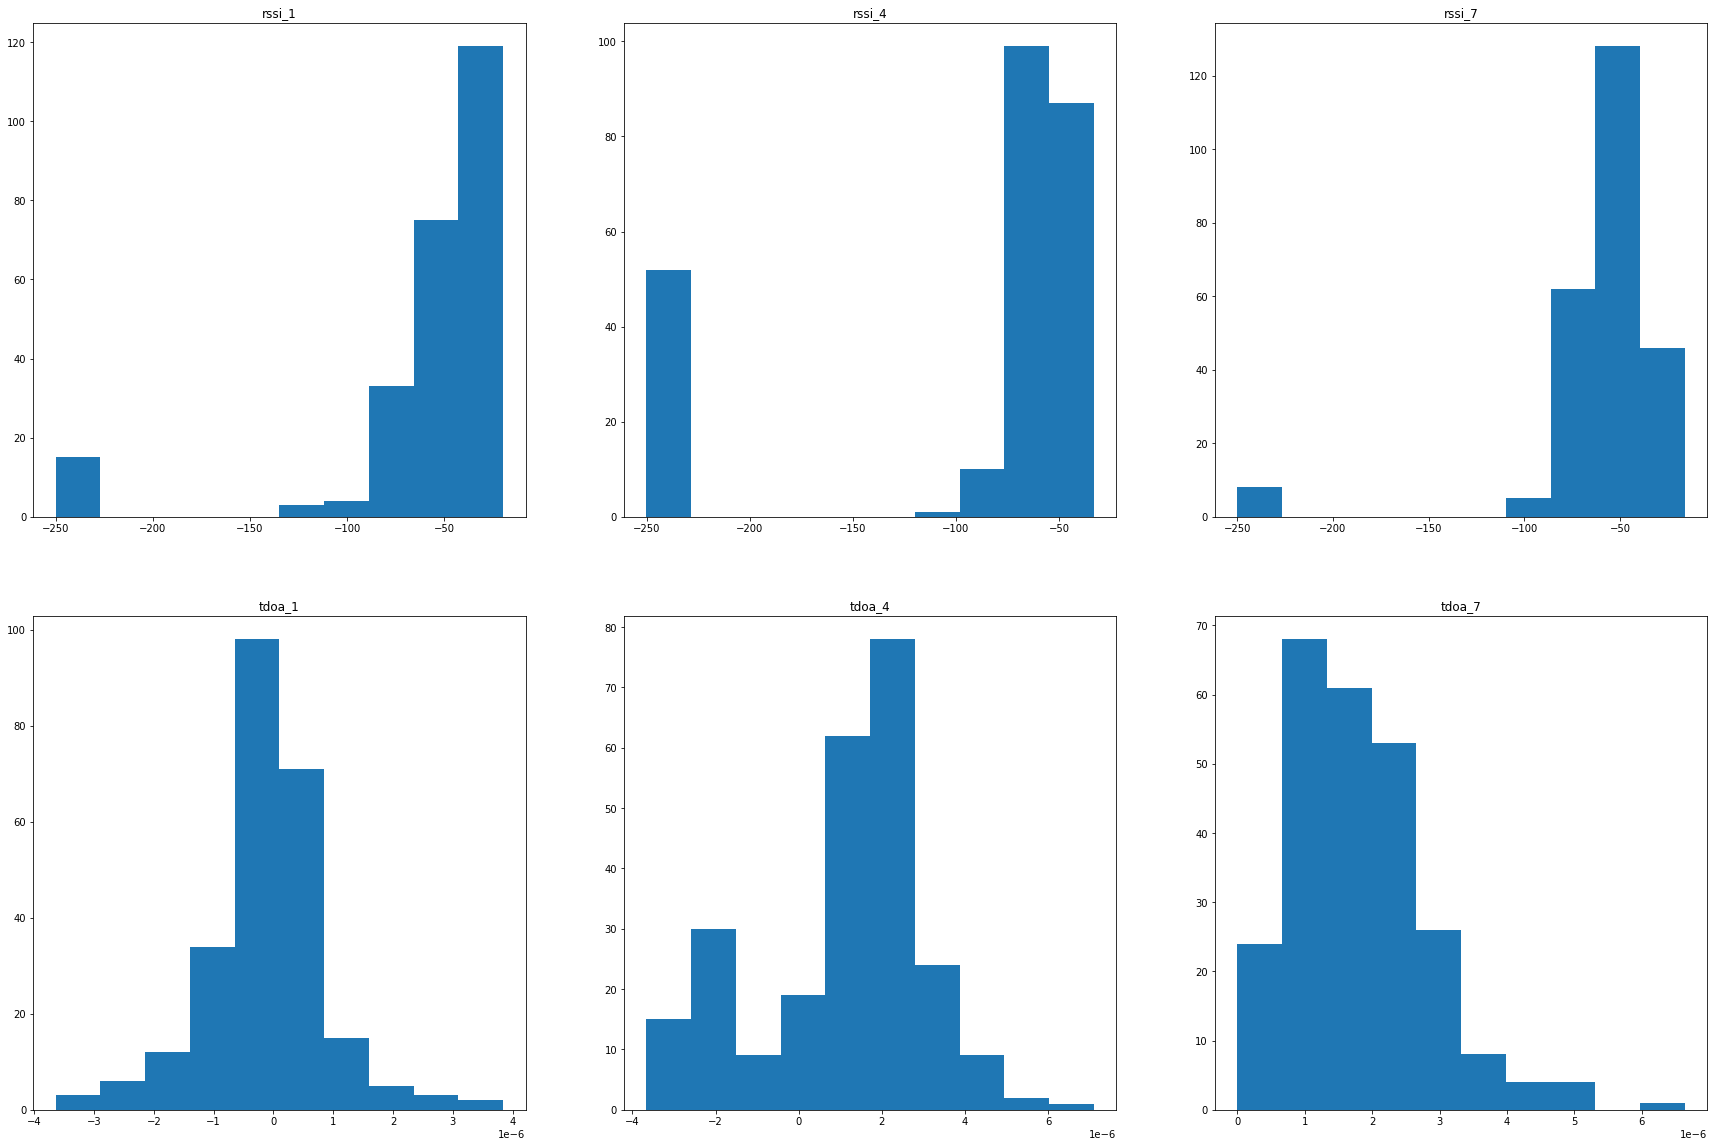

In [174]:
# Observe histograms of RSSI values from three base stations and TDoA values from three base stations
# Take the mean of readings from each reference point
rssi_1_data = actual_rps_df['rssi_1']
rssi_4_data = actual_rps_df['rssi_4']
rssi_7_data = actual_rps_df['rssi_7']

tdoa_1_data = actual_rps_df['tdoa_1']
tdoa_4_data = actual_rps_df['tdoa_4']
tdoa_7_data = actual_rps_df['tdoa_7']

plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(2,3)

axs[0][0].hist(rssi_1_data)
axs[0][0].title.set_text('rssi_1')
axs[0][1].hist(rssi_4_data)
axs[0][1].title.set_text('rssi_4')
axs[0][2].hist(rssi_7_data)
axs[0][2].title.set_text('rssi_7')

axs[1][0].hist(tdoa_1_data)
axs[1][0].title.set_text('tdoa_1')
axs[1][1].hist(tdoa_4_data)
axs[1][1].title.set_text('tdoa_4')
axs[1][2].hist(tdoa_7_data)
axs[1][2].title.set_text('tdoa_7')

In [175]:
# Use lambda function to get the scaled values of RSSI and TDoA
for i in range(1,8):
    
    scaled_rssi = f'scaled_rssi_{i}'
    scaled_tdoa = f'scaled_tdoa_{i}'
    
    min_rssi = actual_rps_df[f'rssi_{i}'].min()
    max_rssi = actual_rps_df[f'rssi_{i}'].max()
    
    min_tdoa = actual_rps_df[f'tdoa_{i}'].min()
    max_tdoa = actual_rps_df[f'tdoa_{i}'].max()
    
    actual_rps_df[scaled_rssi] = actual_rps_df[f'rssi_{i}'].apply(lambda x: scale_down(x, min_rssi, max_rssi))
    actual_rps_df[scaled_tdoa] = actual_rps_df[f'tdoa_{i}'].apply(lambda x: scale_down(x, min_tdoa, max_tdoa))  

In [176]:
actual_rps_df.head(5)

,rp_index,rssi_1,tdoa_1,rssi_2,tdoa_2,rssi_3,tdoa_3,rssi_4,tdoa_4,rssi_5,...,scaled_rssi_3,scaled_tdoa_3,scaled_rssi_4,scaled_tdoa_4,scaled_rssi_5,scaled_tdoa_5,scaled_rssi_6,scaled_tdoa_6,scaled_rssi_7,scaled_tdoa_7
0,0.0,-112.699389,-6.114592e-08,-40.506879,-6.827317e-07,-75.721837,4.475735e-07,-250.095429,-0.000002,-52.446473,...,0.796421,0.448863,0.000560,0.110726,0.866372,NaN,0.914225,0.265442,0.920682,0.148690
1,1.0,-53.280194,9.390514e-07,-35.676996,-4.662520e-07,-75.969840,6.546643e-07,-249.835631,-0.000002,-56.714162,...,0.795289,0.466236,0.001756,0.138504,0.847651,NaN,0.896171,0.247987,0.939123,0.129690
2,2.0,-75.627562,-9.216789e-07,-44.261304,-1.456547e-06,-95.937745,5.058945e-07,-249.868644,-0.000003,-64.615243,...,0.704106,0.453756,0.001604,0.063725,0.812992,NaN,0.887590,0.233567,0.946974,0.137109
3,3.0,-250.028781,-2.116938e-06,-37.222663,-4.089625e-07,-54.293762,1.218730e-06,-64.853840,0.000003,-116.754853,...,0.894272,0.513556,0.853231,0.613245,0.584278,NaN,0.895704,0.297782,0.854330,0.269778
4,4.0,-250.052709,-1.661306e-06,-37.231134,1.778100e-07,-62.362595,2.693477e-06,-77.907933,0.000004,-49.915859,...,0.857426,0.637274,0.793143,0.735193,0.877472,NaN,0.882552,0.207435,0.848252,0.140058


In [177]:
# Replace scaled_tdoa_5 NAs with 0s since BS5 (734817) is the base station with greatest RSSI most of the time hence, 0 TDOA
actual_rps_df['scaled_tdoa_5'] = actual_rps_df['scaled_tdoa_5'].fillna(0.)
actual_rps_df.head(5)

,rp_index,rssi_1,tdoa_1,rssi_2,tdoa_2,rssi_3,tdoa_3,rssi_4,tdoa_4,rssi_5,...,scaled_rssi_3,scaled_tdoa_3,scaled_rssi_4,scaled_tdoa_4,scaled_rssi_5,scaled_tdoa_5,scaled_rssi_6,scaled_tdoa_6,scaled_rssi_7,scaled_tdoa_7
0,0.0,-112.699389,-6.114592e-08,-40.506879,-6.827317e-07,-75.721837,4.475735e-07,-250.095429,-0.000002,-52.446473,...,0.796421,0.448863,0.000560,0.110726,0.866372,0.0,0.914225,0.265442,0.920682,0.148690
1,1.0,-53.280194,9.390514e-07,-35.676996,-4.662520e-07,-75.969840,6.546643e-07,-249.835631,-0.000002,-56.714162,...,0.795289,0.466236,0.001756,0.138504,0.847651,0.0,0.896171,0.247987,0.939123,0.129690
2,2.0,-75.627562,-9.216789e-07,-44.261304,-1.456547e-06,-95.937745,5.058945e-07,-249.868644,-0.000003,-64.615243,...,0.704106,0.453756,0.001604,0.063725,0.812992,0.0,0.887590,0.233567,0.946974,0.137109
3,3.0,-250.028781,-2.116938e-06,-37.222663,-4.089625e-07,-54.293762,1.218730e-06,-64.853840,0.000003,-116.754853,...,0.894272,0.513556,0.853231,0.613245,0.584278,0.0,0.895704,0.297782,0.854330,0.269778
4,4.0,-250.052709,-1.661306e-06,-37.231134,1.778100e-07,-62.362595,2.693477e-06,-77.907933,0.000004,-49.915859,...,0.857426,0.637274,0.793143,0.735193,0.877472,0.0,0.882552,0.207435,0.848252,0.140058


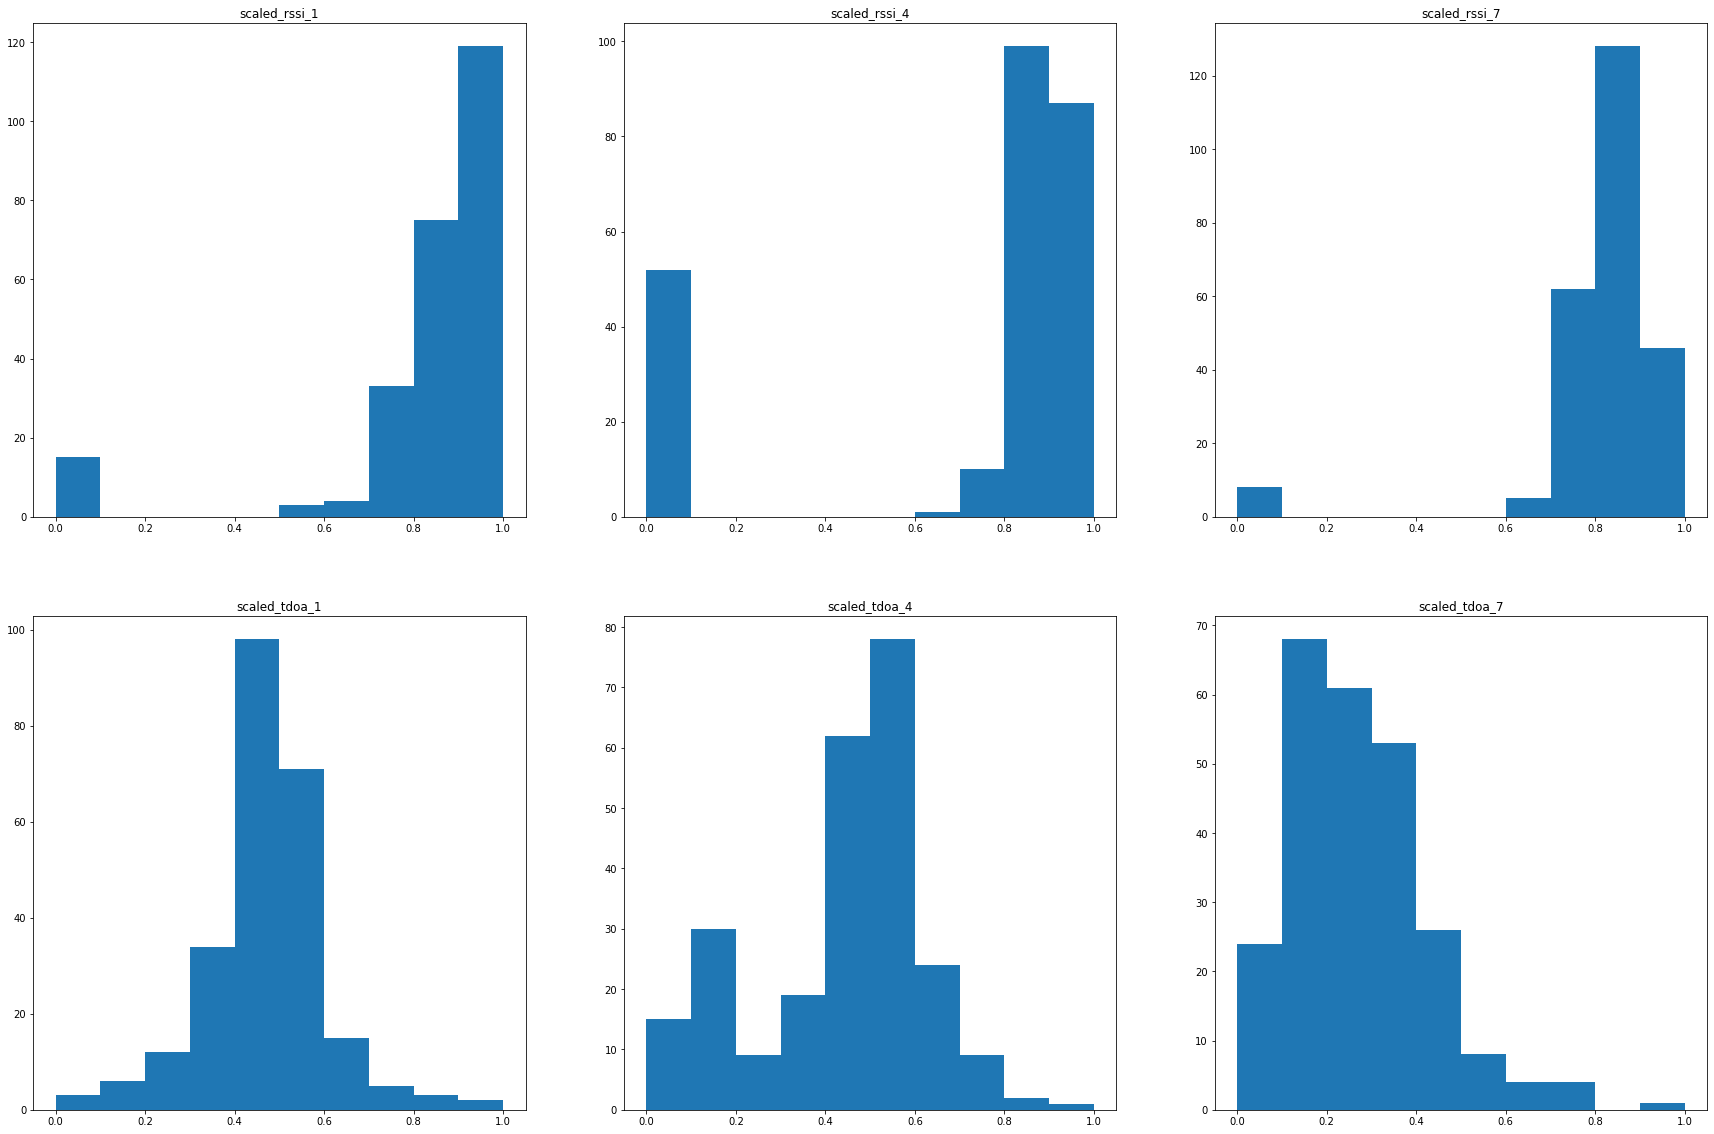

In [178]:
# Distribution is kept - Okay to use scaling to a range to scale data to keep distribution of data
# Observe histograms of RSSI values from three base stations and TDoA values from three base stations
# Take the mean of readings from each reference point
rssi_1_data = actual_rps_df['scaled_rssi_1']
rssi_4_data = actual_rps_df['scaled_rssi_4']
rssi_7_data = actual_rps_df['scaled_rssi_7']

tdoa_1_data = actual_rps_df['scaled_tdoa_1']
tdoa_4_data = actual_rps_df['scaled_tdoa_4']
tdoa_7_data = actual_rps_df['scaled_tdoa_7']

plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(2,3)

axs[0][0].hist(rssi_1_data)
axs[0][0].title.set_text('scaled_rssi_1')
axs[0][1].hist(rssi_4_data)
axs[0][1].title.set_text('scaled_rssi_4')
axs[0][2].hist(rssi_7_data)
axs[0][2].title.set_text('scaled_rssi_7')

axs[1][0].hist(tdoa_1_data)
axs[1][0].title.set_text('scaled_tdoa_1')
axs[1][1].hist(tdoa_4_data)
axs[1][1].title.set_text('scaled_tdoa_4')
axs[1][2].hist(tdoa_7_data)
axs[1][2].title.set_text('scaled_tdoa_7')

In [179]:
# Get graph for known RPs
adj_matrix = W_matrix[:249, :249]
print(adj_matrix.shape)

import networkx as nx

class GraphVisualisation:
    
    def __init__(self, adj_matrix):
        
        self.graph = nx.Graph()
        self.nodes = self.graph.nodes()
        self.edges = self.graph.edges()
        self.get_edges(adj_matrix)
        
    def get_edges(self, adj_matrix):
        
        edges = []
        num_vertices = len(adj_matrix)
        
        for i in range(num_vertices):
            for j in range(i, num_vertices):
                
                if adj_matrix[i][j] != 0:
                    self.graph.add_edge(i, j, weight = adj_matrix[i][j])
    
    def visualise(self):
        nx.draw_networkx(self.graph, node_size = 500)
        plt.show()

(249, 249)


In [180]:
actual_rp_graph = GraphVisualisation(adj_matrix)

In [181]:
from itertools import count

# Only extract values from first base station, rssi1 and tdoa1

for node_idx in actual_rp_graph.graph.nodes():

    rssi_1 = actual_rps_df[actual_rps_df['rp_index'] == node_idx]['rssi_1']
    actual_rp_graph.graph.nodes[node_idx]['rssi_1'] = rssi_1.values[0]
        
    tdoa_1 = actual_rps_df[actual_rps_df['rp_index'] == node_idx]['tdoa_1']
    actual_rp_graph.graph.nodes[node_idx]['tdoa_1'] = tdoa_1.values[0]

rssi_attribute = {}
tdoa_attribute = {}

for node_idx in actual_rp_graph.graph.nodes():
    
    rssi_attribute[node_idx] = actual_rp_graph.nodes[node_idx]['rssi_1']
    tdoa_attribute[node_idx] = actual_rp_graph.nodes[node_idx]['tdoa_1']

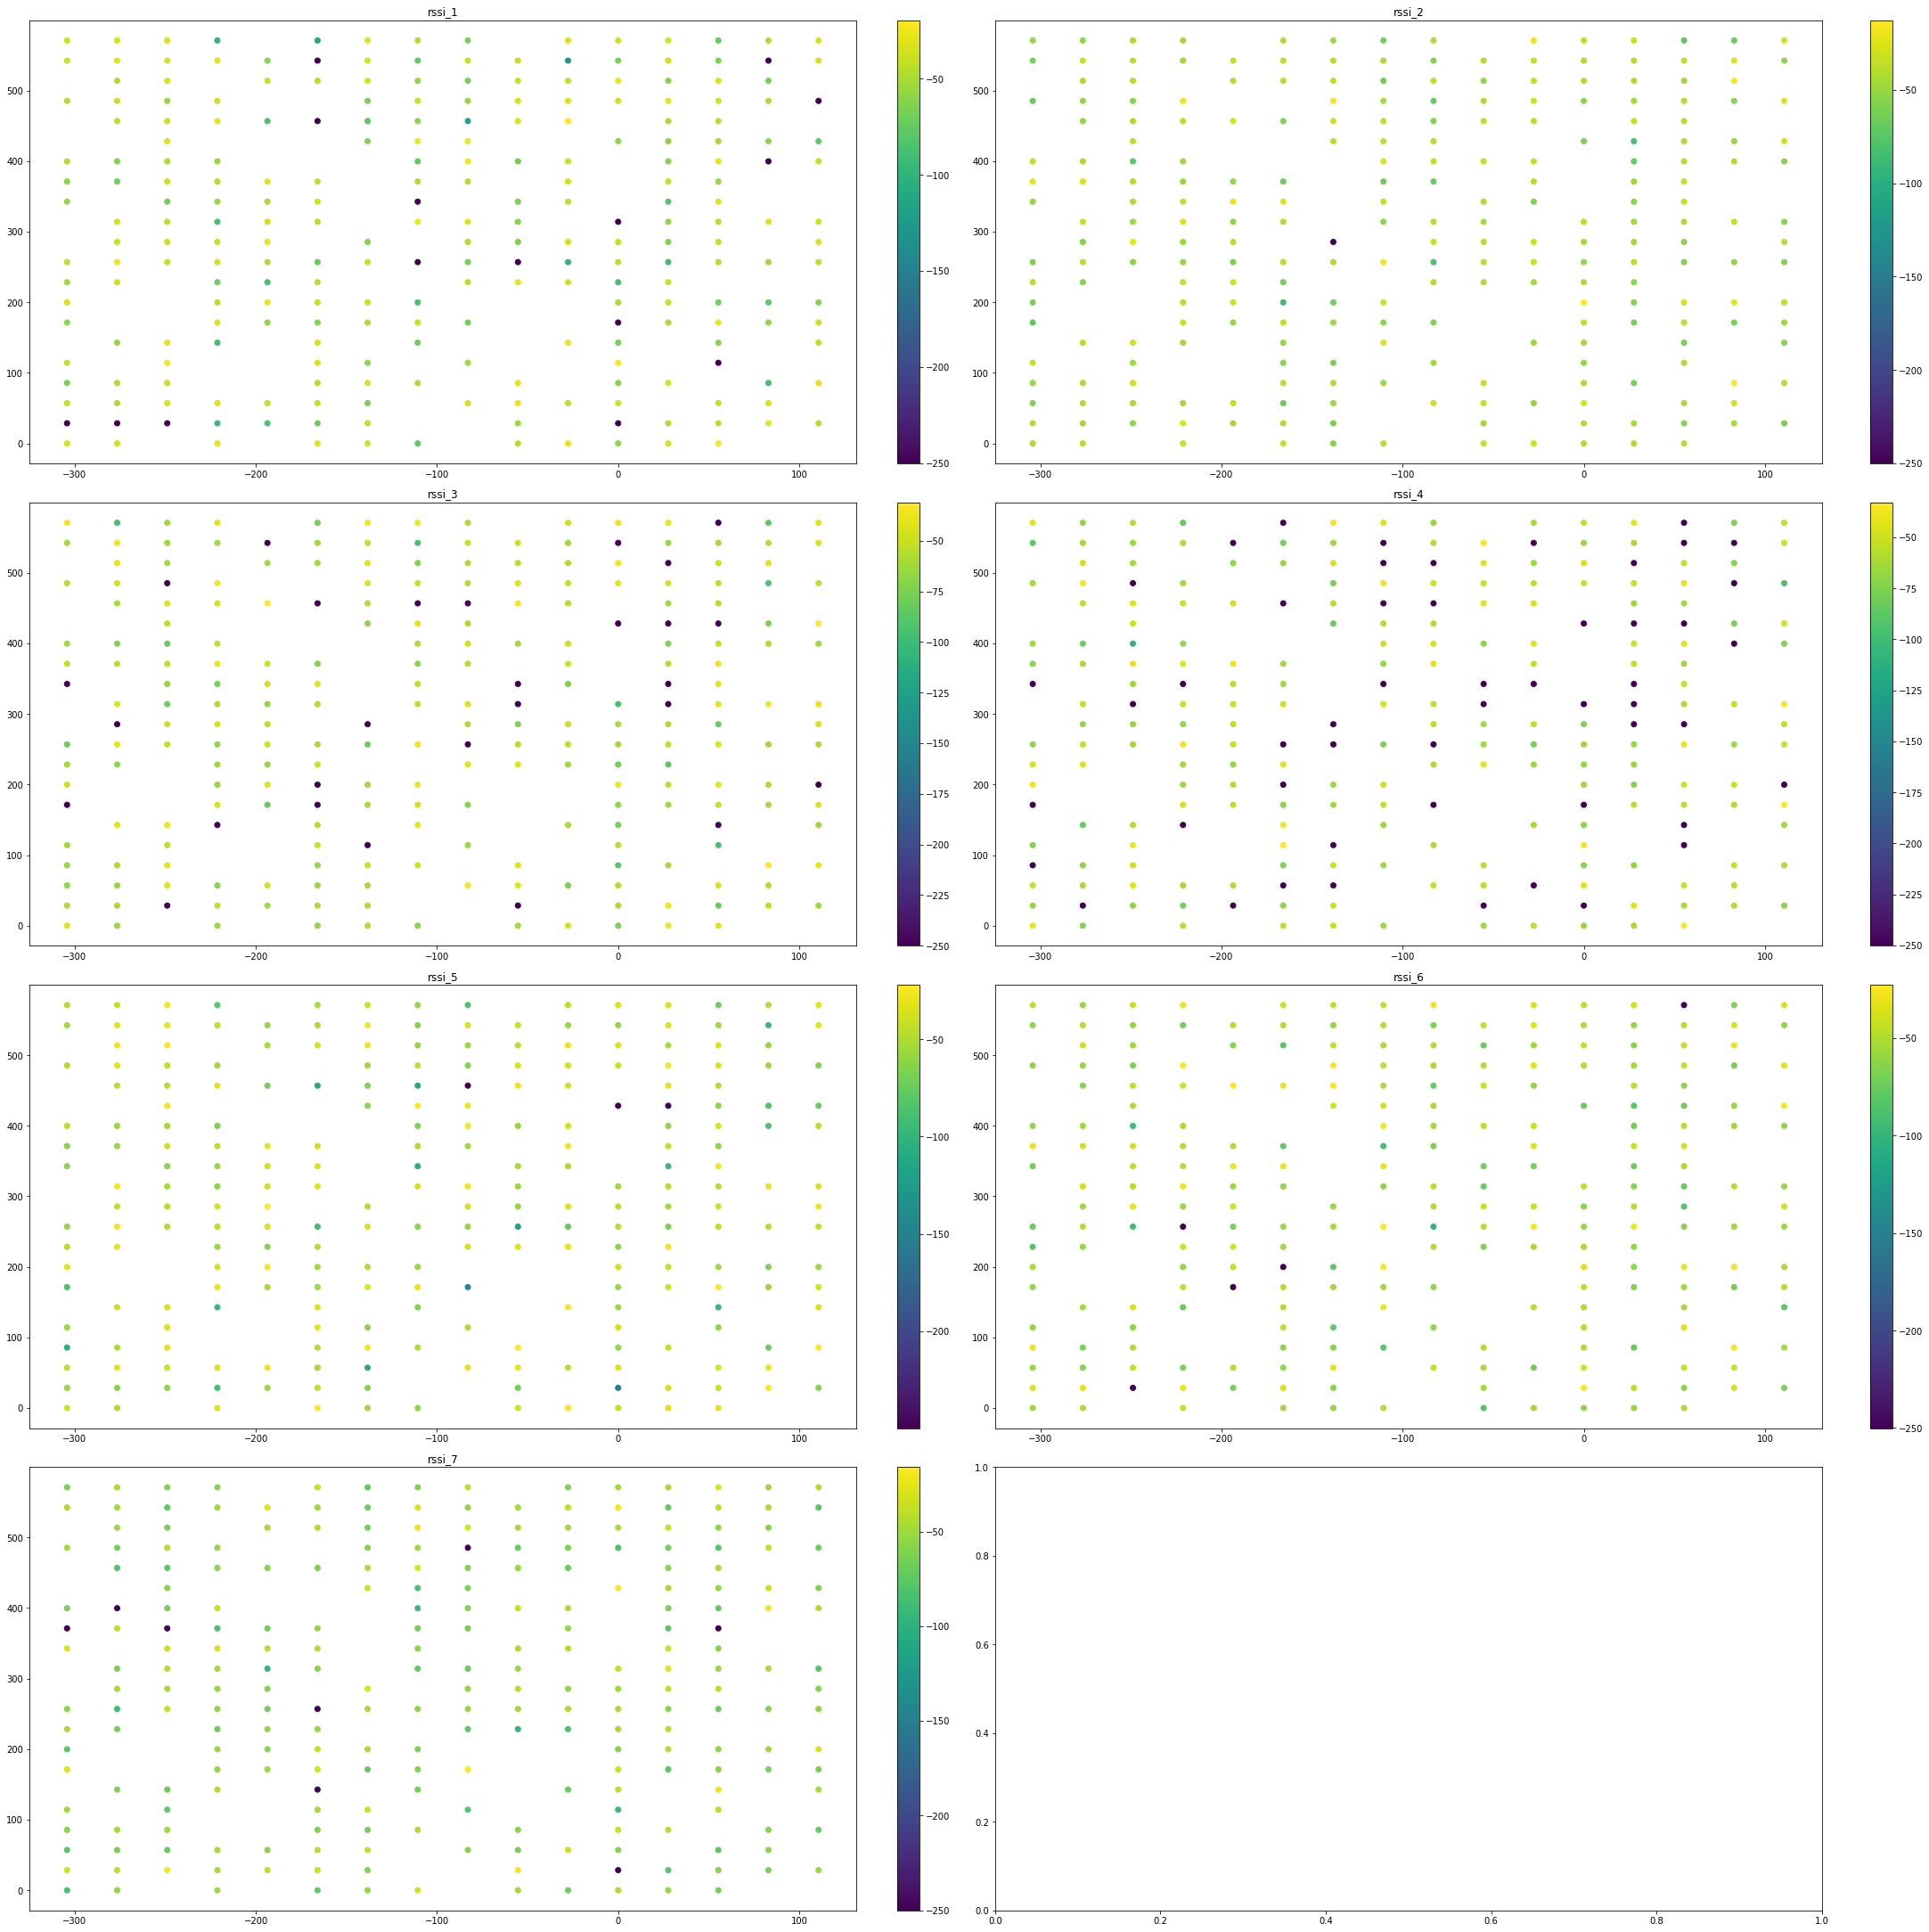

In [182]:
# Visualise on scatter plot
plt.rcParams['figure.figsize'] = [30, 30]

num_row = 4
num_col = 2
fig, axs = plt.subplots(num_row, num_col, constrained_layout = True) 
for i in range(num_row):
    for j in range(num_col):
        
        if (i *2) + j + 1 > ttal_bs:
            break
            
        plot = axs[i][j].scatter(actual_rps_df['rp_x'], actual_rps_df['rp_y'], c = actual_rps_df[f'rssi_{(i*2) + j + 1}'])
        axs[i,j].title.set_text(f'rssi_{(i*2) + j + 1}')
        plt.colorbar(plot, ax = axs[i, j])

/tmp/ipykernel_27713/1623182650.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rps_df['is_parent'] = selected_rps_df['rp_index'].map(lambda idx: idx == node_idx)
/tmp/ipykernel_27713/1623182650.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  axs[i, 1].plot(x,y, 'bo', color = 'b')
/tmp/ipykernel_27713/1623182650.py:108: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  axs[i, 1].plot(x,y, 'bo', color = 'r')


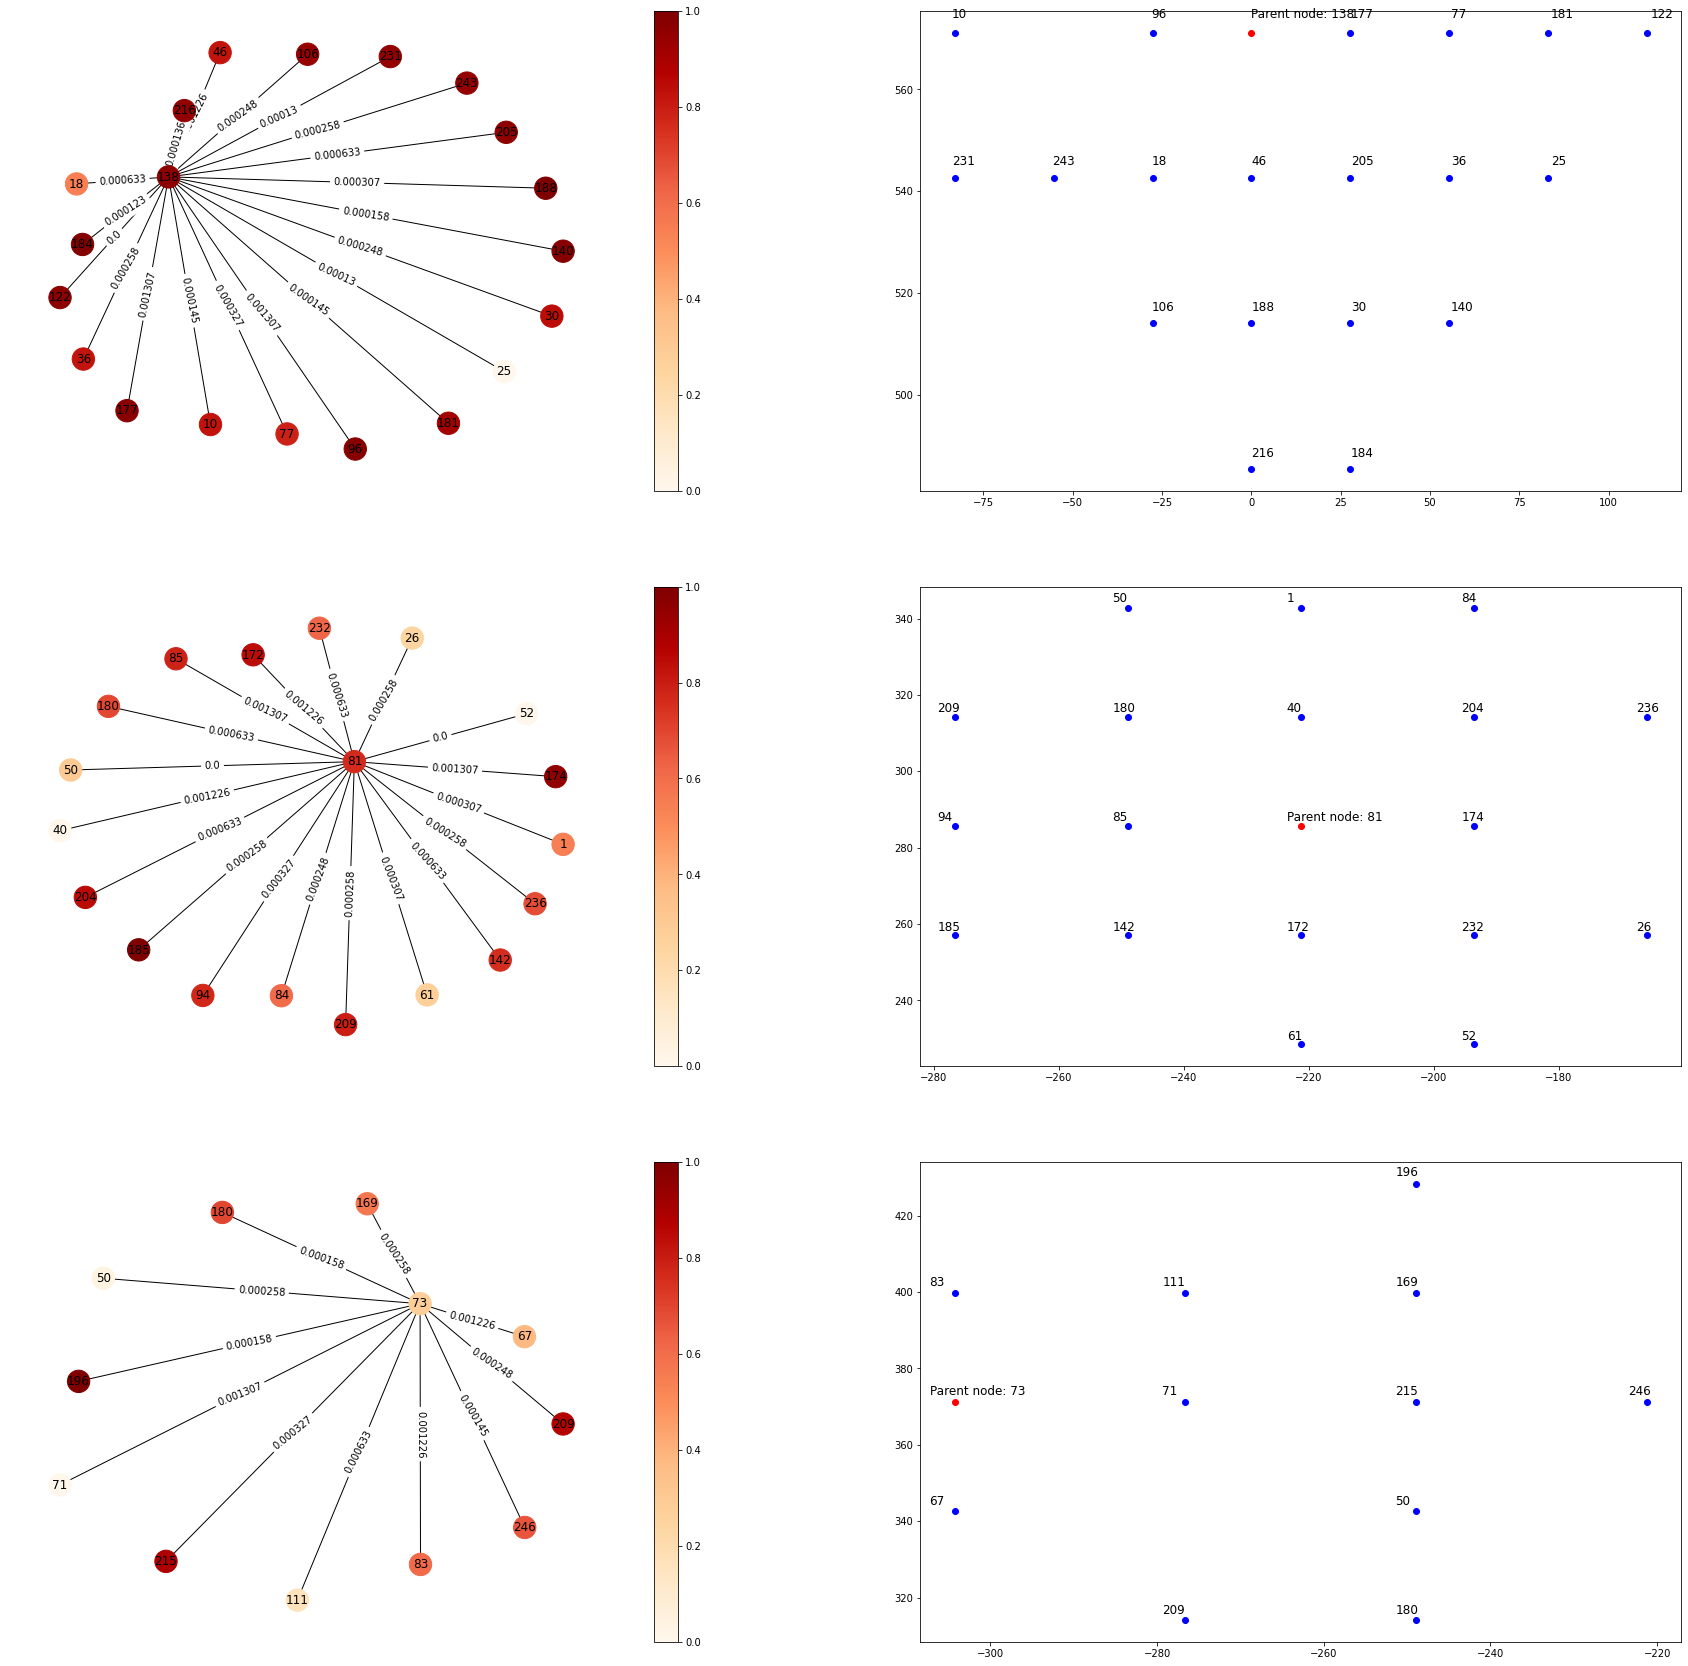

In [183]:
# Purpose of this block of code: To observe if our chosen form of graphical representation is able to make sense of difference in RSSI and TDOA readings
# Achieve this by selecting three random nodes in our graph, choose the top 10 nearest neighbours and:
# 1. Observe the edge weight
# 2. Plot out parent node and neighbours and observe their spatial distribution

import random
from itertools import count
    
# Pick out 3 random nodes
selected_nodes = []

while len(selected_nodes) < 3:
    random_nodeidx = random.randint(0,248)
    if random_nodeidx not in selected_nodes:
        selected_nodes.append(random_nodeidx)
        
plt.rcParams['figure.figsize'] = [30, 30]
fig, axs = plt.subplots(3,2)

# For each node, get all its neighbours
nodes_dict = {}
for i in range(len(selected_nodes)):
    
    # Get neighbours
    node_idx = selected_nodes[i]
    node_edges = list(actual_rp_graph.edges(node_idx))
    neighbours = [node_edges[i][1] for i in range(len(node_edges))]
    
    # Do two subplot
    # One plot draws out the graph with node and its neighbours, showing normalised measurement value and edge weight
    # Make network graph with all interested edges
    G = nx.Graph()
    for edge in node_edges:
        G.add_edge(edge[0], edge[1], weight = W_matrix[edge[0]][edge[1]])        

    # Only extract values from first base station, rssi1 and tdoa1

    for node in G.nodes():

        rssi_1 = actual_rps_df[actual_rps_df['rp_index'] == node]['rssi_1']
        G.nodes[node]['rssi_1'] = rssi_1.values[0]

    rssi_attribute = {}
    
    for node in G.nodes():

        rssi_attribute[node] = G.nodes[node]['rssi_1']
        
    # Plot network graph with edge weights and colour of nodes depdending on measurement value
    min_rssi_value = min(rssi_attribute.values())
    max_rssi_value = max(rssi_attribute.values())

    normalised_rssi = {
        node: (rssi_value - min_rssi_value) / (max_rssi_value - min_rssi_value)
        for node, rssi_value in rssi_attribute.items()
    }

    # You can choose a colormap for continuous values (e.g., 'viridis', 'coolwarm', 'hot', etc.)
    cmap = plt.cm.get_cmap('OrRd')

    # Create a list of colors for each node based on the normalized attributes
    node_colours = [cmap(attr_value) for attr_value in normalised_rssi.values()]

    # Draw the graph with specified node colors
    pos = nx.spring_layout(G)  # You can use other layout algorithms as well
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # Round up the edge labels to 6d.p.s
    for key, value in enumerate(edge_labels):
        edge_labels[value] = round(edge_labels[value], 6)
    
    # Draw graph and weights
    nx.draw(G, pos, with_labels=True, node_color=node_colours, cmap=cmap, node_size = 500,
            ax = axs[i, 0])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, ax = axs[i, 0])
    
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(node_colours)
    plt.colorbar(sm, ax = axs[i, 0])
    
    # One plot is a coordinate plot of node and its neighbours
    # Get all node indexes
    # Get x and y coordinates
    neighbours.append(node_idx)
    selected_rps_df = actual_rps_df.iloc[neighbours]
    
    # Label which is parent, which is neighbour
    selected_rps_df['is_parent'] = selected_rps_df['rp_index'].map(lambda idx: idx == node_idx) 

    # Get labels for points and if point is the parent point
    coord_points = []
    for j in range(len(selected_rps_df)):
        rp_index = selected_rps_df.iloc[j]['rp_index']
        x_coord = selected_rps_df.iloc[j]['rp_x']
        y_coord = selected_rps_df.iloc[j]['rp_y']
        is_parent = selected_rps_df.iloc[j]['is_parent']
        coord_points.append((rp_index, x_coord, y_coord, is_parent))

    # Scatter plot with hue based on label
    cmap = plt.get_cmap('viridis')
    for j in range(len(coord_points)):
        idx = coord_points[j][0]
        x = coord_points[j][1]
        y = coord_points[j][2]
        is_parent = coord_points[j][3]
        
        if is_parent:
            axs[i, 1].plot(x,y, 'bo', color = 'r')
        else:
            axs[i, 1].plot(x,y, 'bo', color = 'b')
            
        if is_parent:
            axs[i, 1].text(x * (1 + 0.01), y * (1 + 0.005), f'Parent node: {int(idx)}', fontsize = 12)
        else:
            axs[i, 1].text(x * (1 + 0.01), y * (1 + 0.005), int(idx), fontsize = 12)

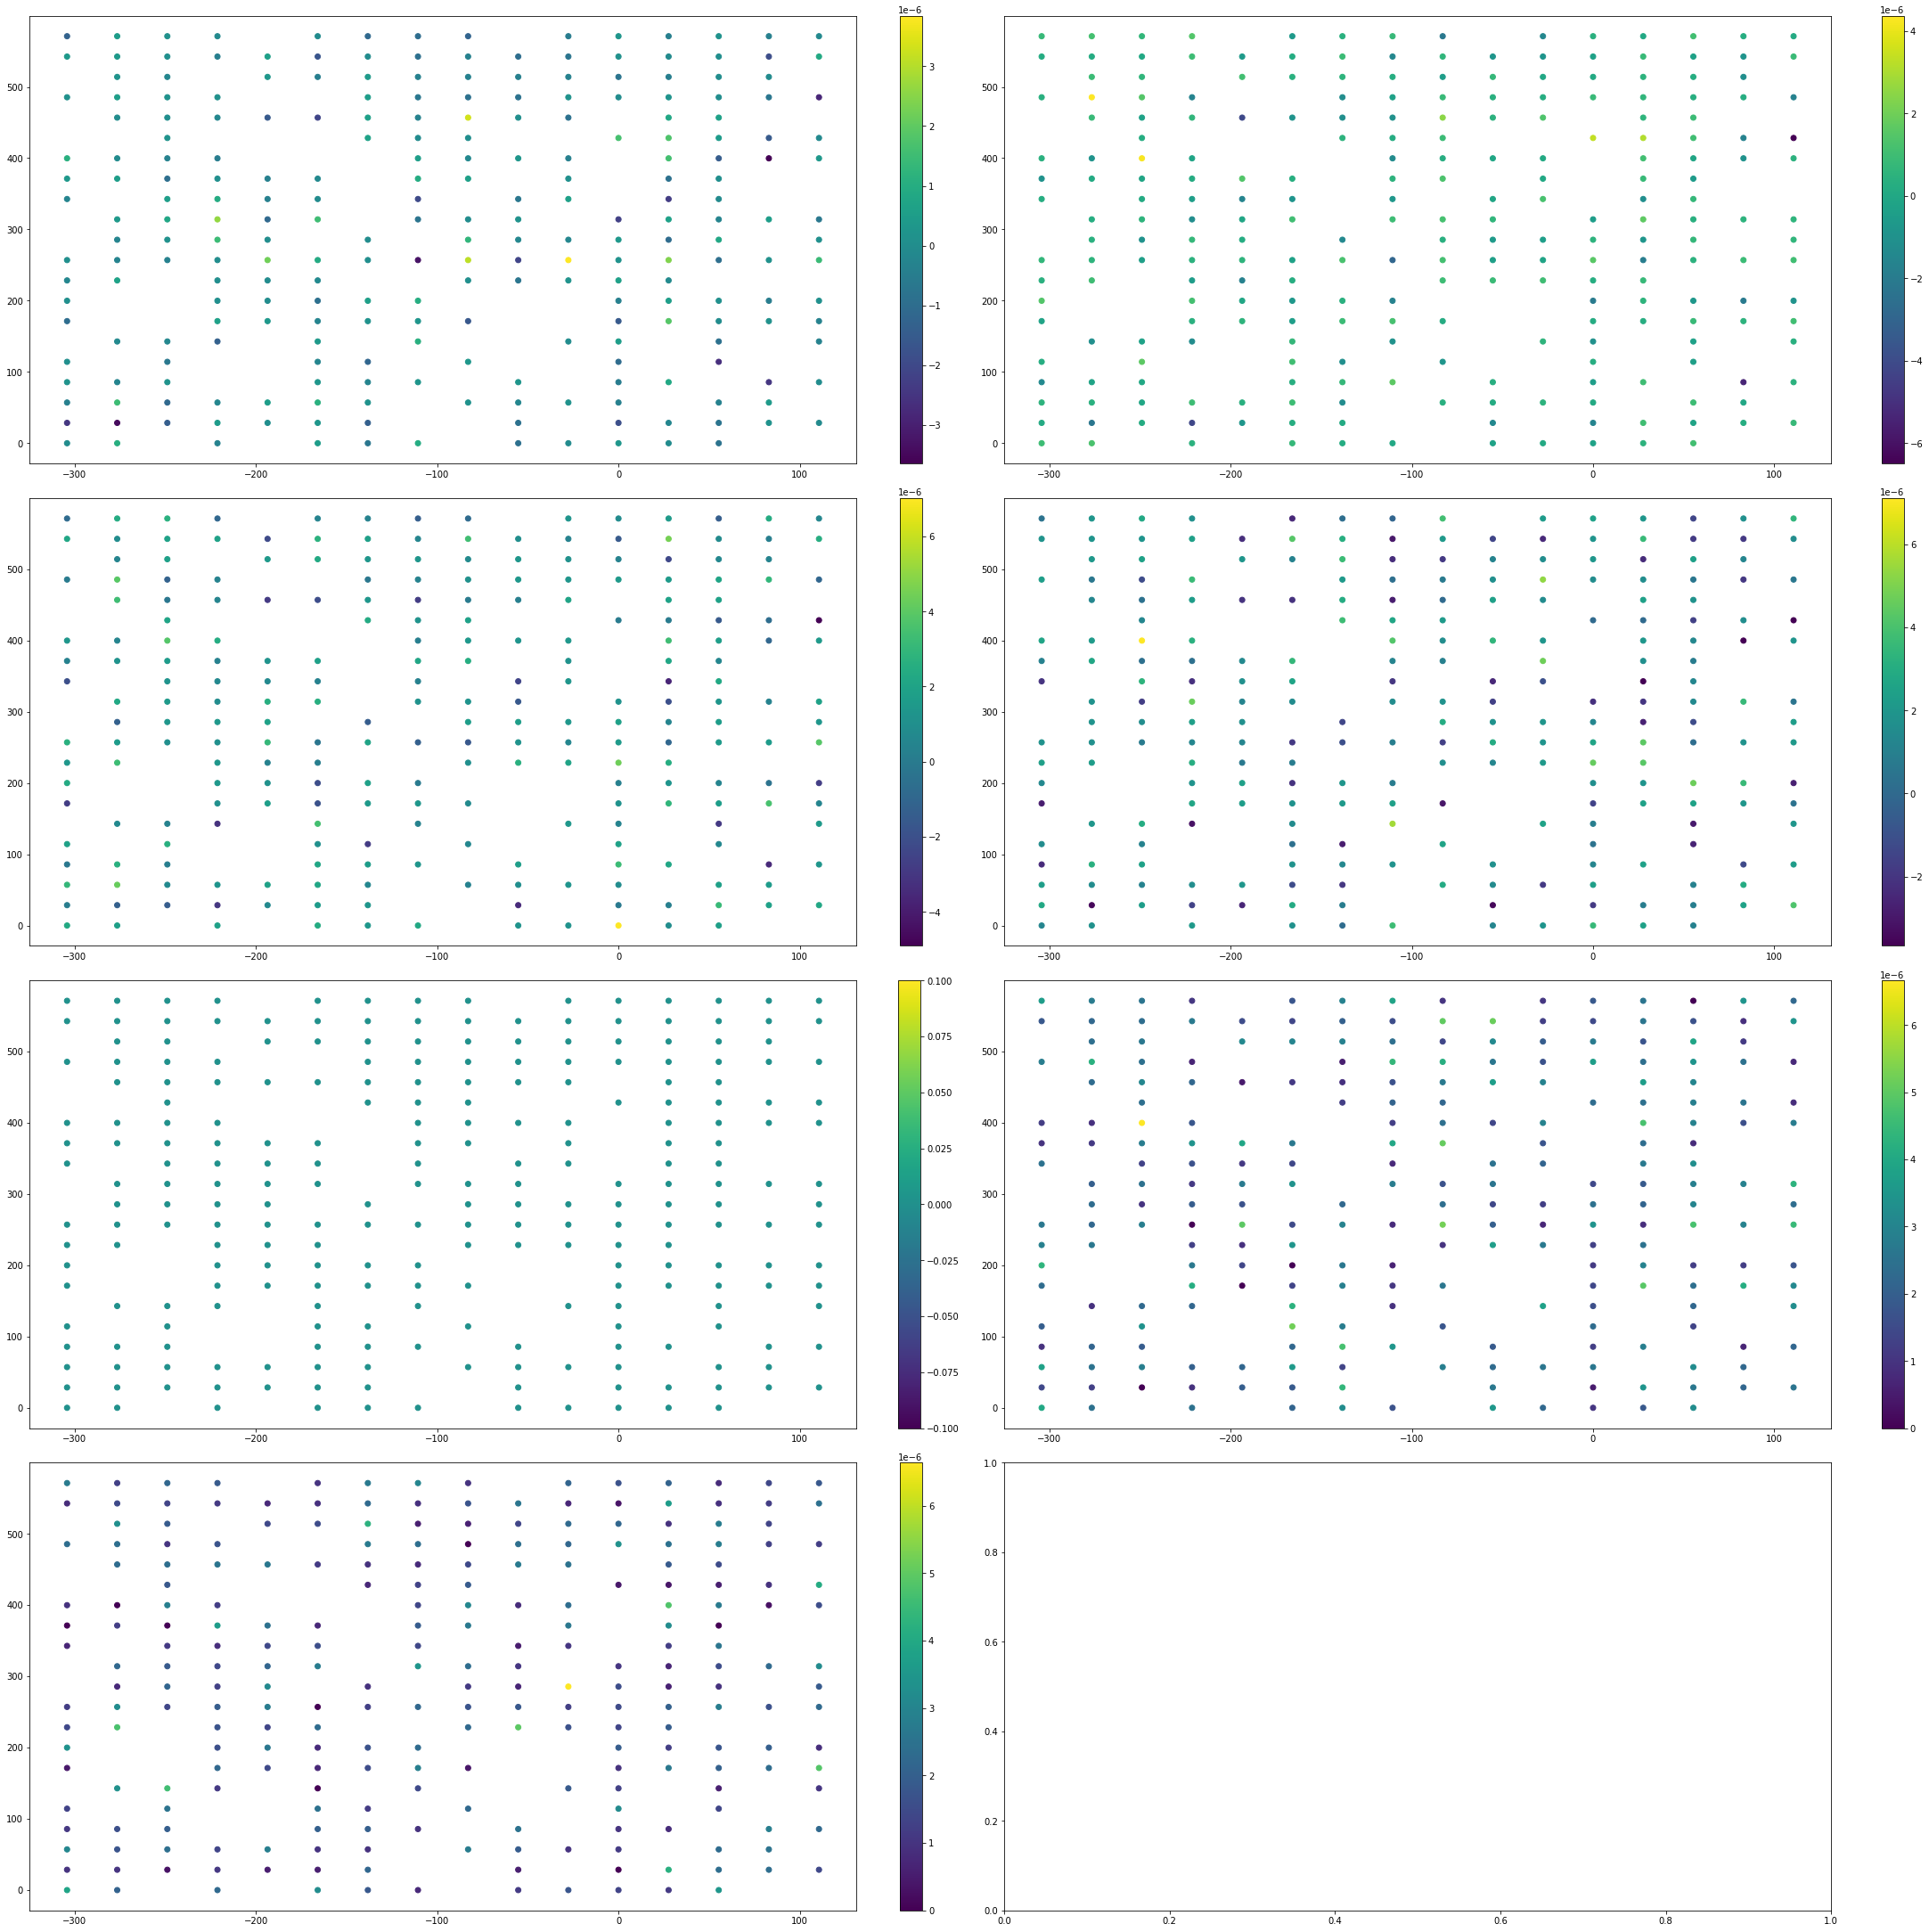

In [184]:
# Visualise on scatter plot
plt.rcParams['figure.figsize'] = [30, 30]

num_row = 4
num_col = 2
fig, axs = plt.subplots(num_row, num_col, constrained_layout = True) 
for i in range(num_row):
    for j in range(num_col):
        
        if (i *2) + j + 1 > ttal_bs:
            break
            
        plot = axs[i][j].scatter(actual_rps_df['rp_x'], actual_rps_df['rp_y'], c = actual_rps_df[f'tdoa_{(i*2) + j + 1}'])
        plt.colorbar(plot, ax = axs[i, j])

/tmp/ipykernel_27713/883442851.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rps_df['is_parent'] = selected_rps_df['rp_index'].map(lambda idx: idx == node_idx)
/tmp/ipykernel_27713/883442851.py:109: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  axs[i, 1].plot(x,y, 'bo', color = 'b')
/tmp/ipykernel_27713/883442851.py:107: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  axs[i, 1].plot(x,y, 'bo', color = 'r')


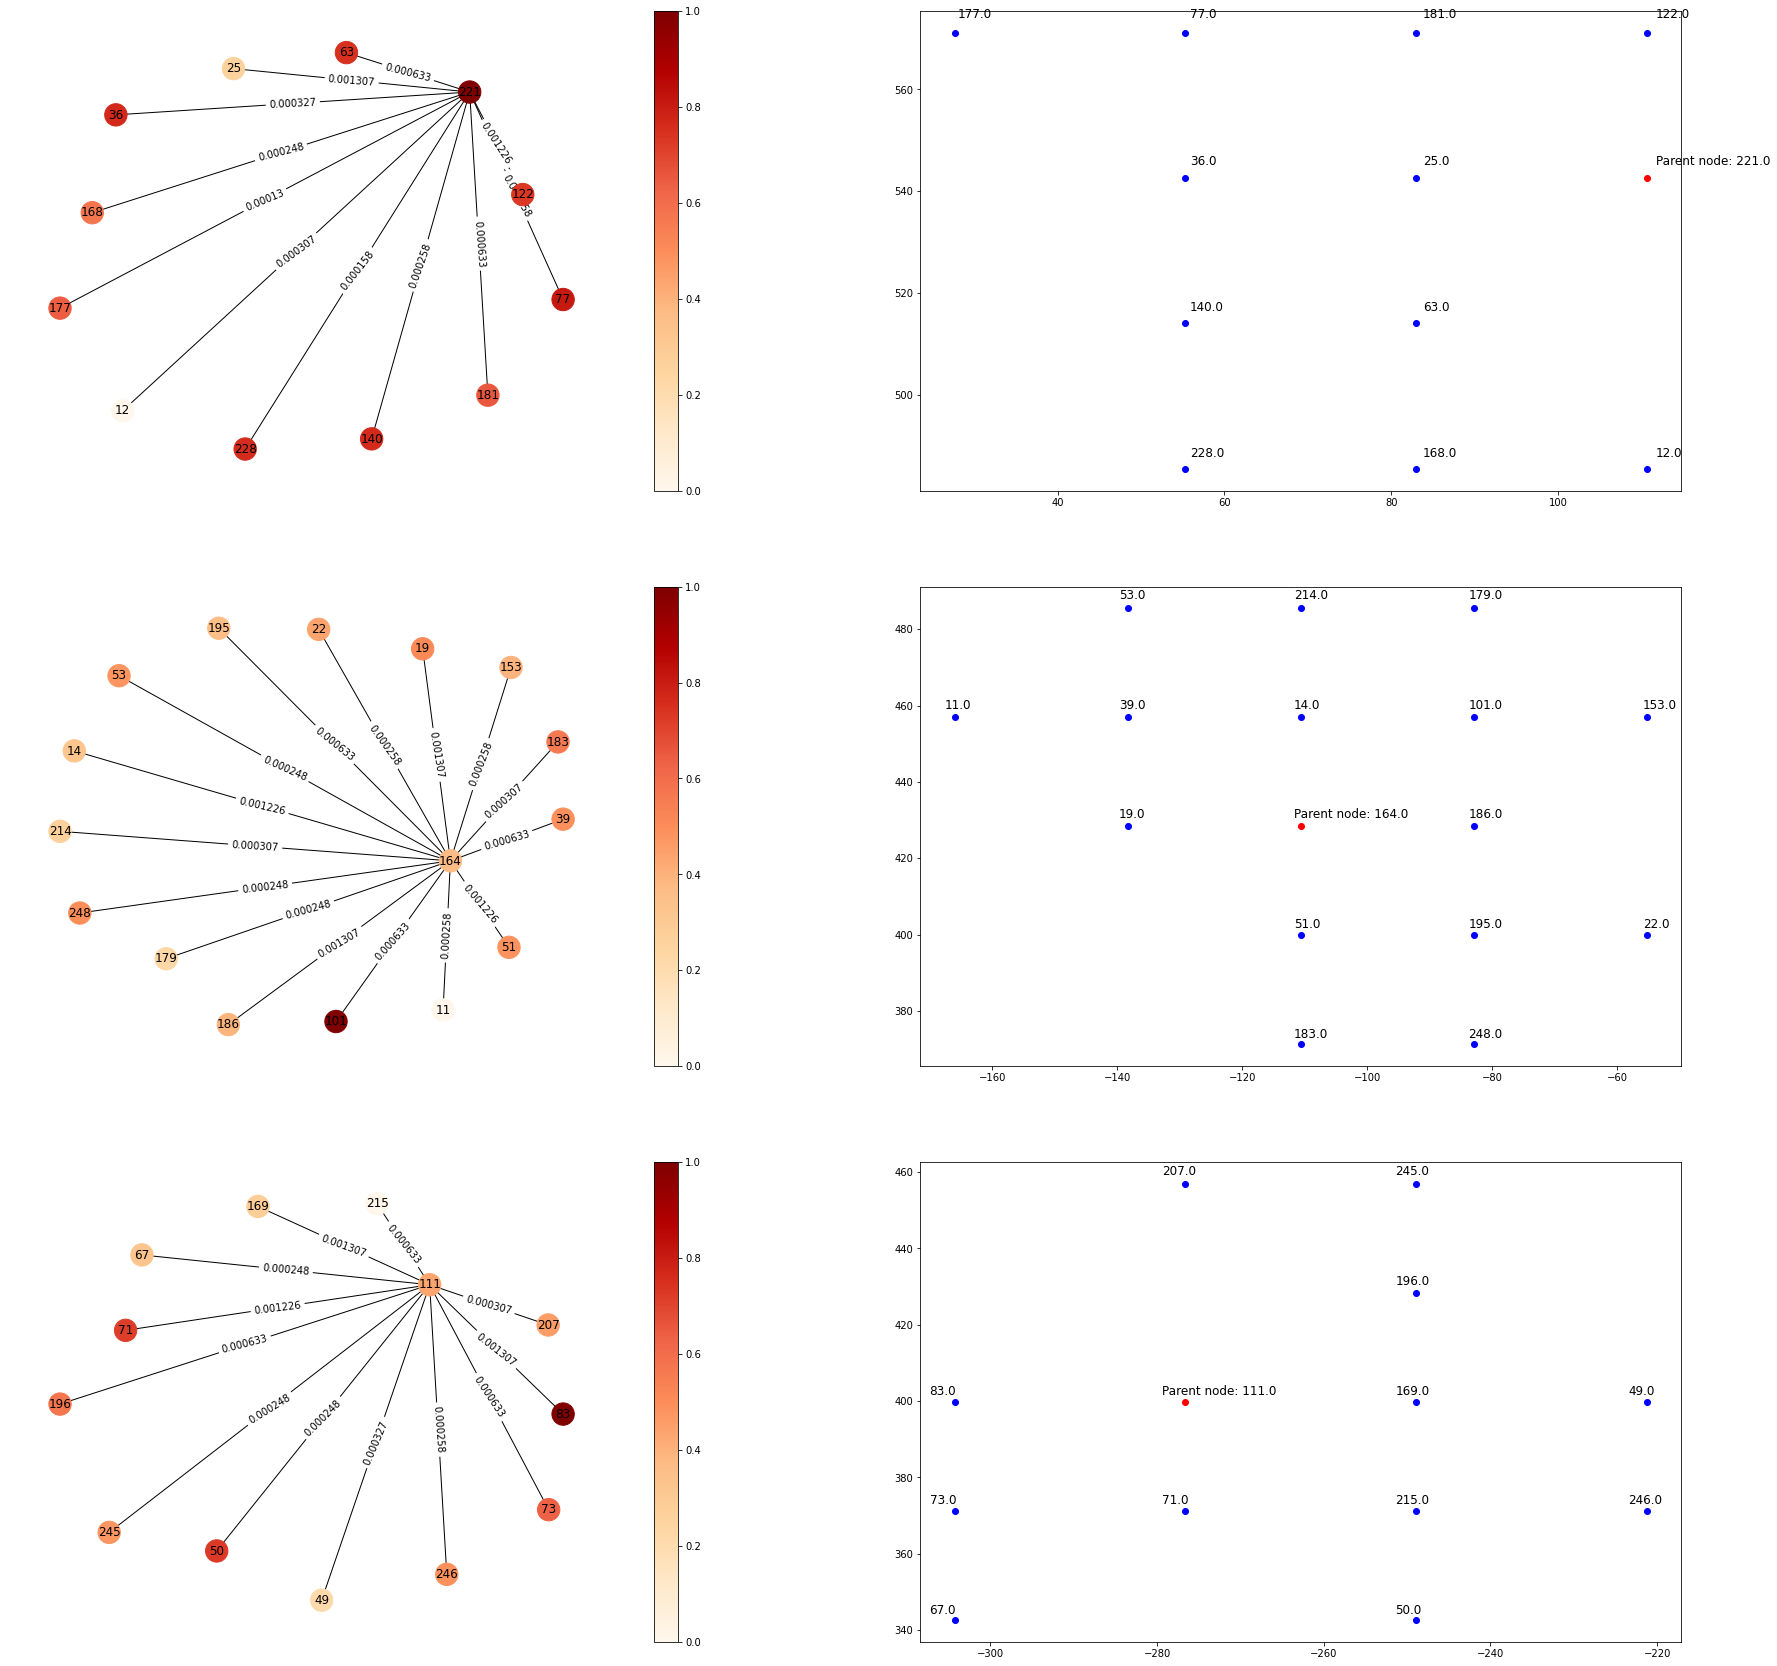

In [185]:
# Purpose of this block of code: To observe if our chosen form of graphical representation is able to make sense of difference in RSSI and TDOA readings
# Achieve this by selecting three random nodes in our graph, choose the top 10 nearest neighbours and:
# 1. Observe the edge weight
# 2. Plot out parent node and neighbours and observe their spatial distribution

import random
from itertools import count
    
# Pick out 3 random nodes
selected_nodes = []

while len(selected_nodes) < 3:
    random_nodeidx = random.randint(0,248)
    if random_nodeidx not in selected_nodes:
        selected_nodes.append(random_nodeidx)
        
plt.rcParams['figure.figsize'] = [30, 30]
fig, axs = plt.subplots(3,2)

# For each node, get all its neighbours
nodes_dict = {}
for i in range(len(selected_nodes)):
    
    # Get neighbours
    node_idx = selected_nodes[i]
    node_edges = list(actual_rp_graph.edges(node_idx))
    neighbours = [node_edges[i][1] for i in range(len(node_edges))]
    
    # Do two subplot
    # One plot draws out the graph with node and its neighbours, showing normalised measurement value and edge weight
    # Make network graph with all interested edges
    G = nx.Graph()
    for edge in node_edges:
        G.add_edge(edge[0], edge[1], weight = W_matrix[edge[0]][edge[1]])        

    # Only extract values from first base station, rssi1 and tdoa1

    for node in G.nodes():
        tdoa_1 = actual_rps_df[actual_rps_df['rp_index'] == node]['tdoa_1']
        G.nodes[node]['tdoa_1'] = tdoa_1.values[0]

    tdoa_attribute = {}

    for node in G.nodes():

        tdoa_attribute[node] = G.nodes[node]['tdoa_1']
        
    # Plot network graph with edge weights and colour of nodes depdending on measurement value
    min_tdoa_value = min(tdoa_attribute.values())
    max_tdoa_value = max(tdoa_attribute.values())

    normalised_tdoa = {
        node: (tdoa_value - min_tdoa_value) / (max_tdoa_value - min_tdoa_value)
        for node, tdoa_value in tdoa_attribute.items()
    }

    # You can choose a colormap for continuous values (e.g., 'viridis', 'coolwarm', 'hot', etc.)
    cmap = plt.cm.get_cmap('OrRd')

    # Create a list of colors for each node based on the normalized attributes
    node_colours = [cmap(attr_value) for attr_value in normalised_tdoa.values()]

    # Draw the graph with specified node colors
    pos = nx.spring_layout(G)  # You can use other layout algorithms as well
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # Round up the edge labels to 6d.p.s
    for key, value in enumerate(edge_labels):
        edge_labels[value] = round(edge_labels[value], 6)
    
    # Draw graph and weights
    nx.draw(G, pos, with_labels=True, node_color=node_colours, cmap=cmap, node_size = 500,
            ax = axs[i, 0])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, ax = axs[i, 0])
    
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(node_colours)
    plt.colorbar(sm, ax = axs[i, 0])
    
    # One plot is a coordinate plot of node and its neighbours
    # Get all node indexes
    # Get x and y coordinates
    neighbours.append(node_idx)
    selected_rps_df = actual_rps_df.iloc[neighbours]
    
    # Label which is parent, which is neighbour
    selected_rps_df['is_parent'] = selected_rps_df['rp_index'].map(lambda idx: idx == node_idx) 

    # Get labels for points and if point is the parent point
    coord_points = []
    for j in range(len(selected_rps_df)):
        rp_index = selected_rps_df.iloc[j]['rp_index']
        x_coord = selected_rps_df.iloc[j]['rp_x']
        y_coord = selected_rps_df.iloc[j]['rp_y']
        is_parent = selected_rps_df.iloc[j]['is_parent']
        coord_points.append((rp_index, x_coord, y_coord, is_parent))

    # Scatter plot with hue based on label
    cmap = plt.get_cmap('viridis')
    for j in range(len(coord_points)):
        idx = coord_points[j][0]
        x = coord_points[j][1]
        y = coord_points[j][2]
        is_parent = coord_points[j][3]
        
        if is_parent:
            axs[i, 1].plot(x,y, 'bo', color = 'r')
        else:
            axs[i, 1].plot(x,y, 'bo', color = 'b')
            
        if is_parent:
            axs[i, 1].text(x * (1 + 0.01), y * (1 + 0.005), f'Parent node: {idx}', fontsize = 12)
        else:
            axs[i, 1].text(x * (1 + 0.01), y * (1 + 0.005), idx, fontsize = 12)

## Observations:

### RSSI Plot:
- RSSI differs by at most 50dB in the same neighbourhood.
- But not for rssi_4 (bs_734777) where there is much more points with no RSSI compared to other BSs.

### TDoA Plot:
- Distribution of TDoA values over smaller range.
- RPs with no RSSI also has a low values of TDoA.

### Taking into account both plots,
- Underlying assumption: Points in the same vicinity should exhibit a greater degree of similarity compared to points that are further away
- When considering only one BS, no clear relationship between distance apart and difference in value. (Point far away can be close to points nearby)
- But hope that by taking inputs from sufficiently enough Ss will make measurements at each RP descriptive enough so as to differentiate points that are near as compared  to points that are far away.

#### TODO: Repeat the graph plot for at least 3 BS and see if can differentiate nearby RPs from RPs far away

## Step 8: Train model to learn feature representation of unknown nodes

In [330]:
# placeholders can be removed from __init__() function for GraphSAGE and edge iterator 
# Leave it as it is first and decide whether to remove later
placeholders = construct_placeholders()

# Let's first test by using mean of RSSI and TDoA as features
# Get data
actual_rps_coords_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
actual_rps_indexes = actual_rps_coords_df['rp_index'].unique()
actual_rps_measurements = [fp for index, fp in enumerate(fp_array) if index in actual_rps_indexes]
actual_rps_measurements = np.array(actual_rps_measurements)

# Normalise data
# For each of the 14th measurement (col) for each RP sample, find the min and max value
num_features = 14
normalised_features = []

for i in range(num_features):
    
    # Get the i-th measurements for all reference points for all samples
    feature_arr = actual_rps_measurements[:,:,i]
    # print(feature_arr.shape)
    # Find out min and max value for the i-th measurement
    min_val = np.amin(feature_arr)
    max_val = np.amax(feature_arr)
    
    tmp = np.zeros(shape = feature_arr.shape, dtype = np.float32)
    # Iterate over no. of reference points
    for j in range(tmp.shape[0]):
        
        # Iterate over no. of samples
        for k in range(tmp.shape[1]):
            
            # Account for division by 0
            if max_val - min_val == 0:
                tmp[j][k] = 0

            # Perform normalisation using math formula
            else:
                tmp[j][k] = (feature_arr[j][k] - min_val) / (max_val - min_val)
    
    normalised_features.append(tmp)
    
normalised_features = np.array(normalised_features)
# print(normalised_features.shape)

# Get mean of the 100 samples
avg_normalised_features = np.mean(normalised_features, axis = 2)
avg_normalised_features = avg_normalised_features.T
# print(avg_normalised_features.shape)

# print(actual_rps_indexes)
# Get adjacency and degree matrix
# TODO: Check if indexes have been shuffled
adj = W_matrix
degrees = D_matrix

In [331]:
# Create graph needed for model
model_graph = nx.Graph()
num_vertices = len(W_matrix)

# Create the complete graph
for i in range(num_vertices):
    for j in range(num_vertices):
        
        if W_matrix[i][j] != 0:
            model_graph.add_edge(i, j, weight = W_matrix[i][j])

# Label the nodes if they are from train, val or test
# Get the indexes of nodes originally from train and test
X_train_actual_df = X_train_augmented_df[X_train_augmented_df['is_actual'] == 1.0]
X_train_virtual_df = X_train_augmented_df[X_train_augmented_df['is_actual'] != 1.0]

# Actual RP becomes train dataset
actual_rps_indexes = X_train_actual_df['rp_index'].unique()

np.random.shuffle(actual_rps_indexes)
train_size = round(int(len(actual_rps_indexes)*0.95))
print(train_size)
train_rps = actual_rps_indexes[:train_size]
val_rps = actual_rps_indexes[train_size:]

# Virtual RP gets split into validation and test dataset
virtual_rp_indexes = X_train_virtual_df['rp_index'].unique()
test_rps = virtual_rp_indexes

print(train_rps.shape, val_rps.shape, test_rps.shape)

# Mark the vertices in the graph on whether they are train, validation or test
# node_type = 1 for training, 0 for validation and -1 for test
for node_idx in model_graph.nodes():
    
    if node_idx in train_rps:
        model_graph.nodes[node_idx]['train'] = True
        model_graph.nodes[node_idx]['node_type'] = 1
    
    elif node_idx in val_rps:
        model_graph.nodes[node_idx]['val'] = True
        model_graph.nodes[node_idx]['node_type'] = 0
        
    else:
        model_graph.nodes[node_idx]['test'] = True
        model_graph.nodes[node_idx]['node_type'] = -1

236
(236,) (13,) (2500,)


In [332]:
# Get layers information
from collections import namedtuple

SAGEInfo = namedtuple("SAGEInfo",
        ['layer_name', # name of the layer (to get feature embedding etc.)
         'num_samples',
         'output_dim' # the output (i.e., hidden) dimension
        ])
layer_infos = [SAGEInfo("layer_1", 10, 14),
              SAGEInfo("layer_2", 5, 14)]

In [423]:
'''
__init__() method for GraphSAGE model:
   def __init__(self, placeholders, features, adj, degrees, layer_infos,
                 model_name, neg_sample_size, concat = True, model_size = 'small',
                 logging = False, learning_rate = 0.00001, params_decay = 0., **kwargs):
'''
graphsage_model = GraphSAGE(placeholders, avg_normalised_features, model_graph, adj, degrees,
                           layer_infos, 'graphsage_v0', 50, concat = False)

'''def train_model(self, epochs, max_total_steps, validate_every, print_every):'''
# Source code parameters: epochs = 1, max_total_steps = 10**10, validate_every = 5000, print_every = 50 
graphsage_model.train_model(100, 10**5, 500, 50)

Unexpected missing: 0
236 train nodes
13 val nodes
2500 test nodes
Epoch 1
Base samples:  (50, 1)
Negative samples:  (50,)
Base samples:  (10, 1)
Negative samples:  (50,)
Epoch 0, Batch Iteration 0
train_loss: 35.350510
train_mrr: 0.019608
train_mrr_ema: 0.019608
val_loss: 35.350506
val_mrr: 0.019608
val_mrr_ema: 0.019608
average_time: 1.107477
tf.Tensor(
[-0.39634478  0.34124142  0.20643562 -0.3474026   0.06471992 -0.21137321
  0.00560585  0.17194617 -0.25105178 -0.19835097 -0.1982992   0.40918428
 -0.1977711  -0.00259757], shape=(14,), dtype=float32)
Base samples:  (50, 1)
Negative samples:  (50,)
Base samples:  (50, 1)
Negative samples:  (50,)
Base samples:  (50, 1)
Negative samples:  (50,)
Base samples:  (50, 1)
Negative samples:  (50,)
Base samples:  (50, 1)
Negative samples:  (50,)
Base samples:  (50, 1)
Negative samples:  (50,)
Base samples:  (50, 1)
Negative samples:  (50,)
Base samples:  (50, 1)
Negative samples:  (50,)
Base samples:  (50, 1)
Negative samples:  (50,)
Base samp

KeyboardInterrupt: 

In [365]:
## Examining our edge batch iterator to see if training and validation changes correctly
minibatch_test = EdgeMinibatchIterator(model_graph, rp_mapped_dict, nodetype_dict, 
                                 placeholders, max_degree = 50, num_neg_samples = 20)

# Does loaded edges change each time next_minibatch_feed_dict is called? Yes
iter1_dict = minibatch_test.next_minibatch_feed_dict()
print('Batch 1:')
print(iter1_dict['batch1'])
print(iter1_dict['batch2'])

iter1_val_dict = minibatch_test.val_feed_dict(size = 20)
print('Validation batch 1')
print(iter1_val_dict['batch1'])
print(iter1_val_dict['batch2'])

iter2_dict = minibatch_test.next_minibatch_feed_dict()
print('Batch 2:')
print(iter2_dict['batch1'])
print(iter2_dict['batch2'])

Unexpected missing: 0
236 train nodes
13 val nodes
2500 test nodes
Batch 1:
tf.Tensor(
[1686 1676 1688 1713 1706 1741  279 1721 1745 1694  195 1752 1701 1712
 1715 1712 1702 1754 1721 1657 1705 1747 1715 1704 1742 1700 1713 1720
 1703 1746 1745 1745  791 1707 1698 1711 1714 1684   33 1747 1698 1719
 2085 1744 1715 1747 1706 1708 1754 1714], shape=(50,), dtype=int32)
tf.Tensor(
[2137 2632  596 2398  414 1799  377 2254 1132 1622 1875 2415 2135  637
  382 1141 2323  831 1636 1759 2694 1284  416 2147 1058 1606 1574  825
 2211 2656 1738 1509  995  910  696 1219  609 1317 1159 2656 1552 1743
 2281 2332  502 1310 1035  923  588 2376], shape=(50,), dtype=int32)
Validation batch 1
tf.Tensor([2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2], shape=(20,), dtype=int32)
tf.Tensor(
[   4   10   34   53   56  128  157  161  165  179  190  200  214  231
  243 2367 2369 2371 2373 2375], shape=(20,), dtype=int32)
Batch 2:
tf.Tensor(
[1711 2473 1711 1716 1467 1752 1748 1702   55 1760   14 1690 1708  967
 1690 16